## Analysis v5: Detecting Covariant Sites 

In [1]:
import os
import textwrap
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from natsort import index_natsorted

In [2]:
# Set color values
dutchfield = ["#e60049", "#0bb4ff", "#87bc45", "#ef9b20", "#b33dc6"]

springpastel = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a"] 

### Calculating the Variance of the AF and FPS values 

It would be quite interesting to see if for each variant site per motif, the variance of the AF and FPS values are correlated.

I.e. if a variant site has a high variance in AF values, does it also have a high variance in FPS values?

First, load the data file as dataframe and then truncate the columns to include on AF and FPS data. Next, convert the dataframe into long format.

In [5]:
# import the data
# filepath = '/home/users/ntu/suffiazi/scratch/outputs/tmp/input_data/E2F5_E2F5_HUMAN.H11MO.0.B_fpscore-af-varsites-combined-matrix-wide.tsv'
filepath = '../output-data/combined_matrix/TFDP1_M08108_2.00_fpscore-af-varsites-combined-matrix-wide.tsv'
dt_afps = pd.read_csv(filepath, sep='\t')
# extract motif id from filename
motif_id = os.path.basename(filepath).replace('_fpscore-af-varsites-combined-matrix-wide.tsv', '')
motif_id

'TFDP1_M08108_2.00'

In [6]:
dt_afps.head()

Chromosome   Start     End  98JKPD8_lumA_fps  ANAB5F7_basal_fps  \
0       chr1  191257  191268           0.00000            0.00000   
1       chr1  818021  818032           0.02966            0.04399   
2       chr1  818780  818791           0.02572            0.02376   
3       chr1  960570  960581           0.28046            0.33500   
4       chr1  977015  977026           1.10047            0.50514   

   S6R691V_her2_fps  PU24GB8_lumB_fps  2GAMBDQ_norm_fps  \
0           0.00000           0.00000           0.00000   
1           0.02131           0.03470           0.03443   
2           0.02271           0.02814           0.03391   
3           0.28495           0.27618           0.22986   
4           0.71035           1.21305           1.30155   

   2GAMBDQ_norm_varsite_pos 2GAMBDQ_norm_ref_allele  ... ANAB5F7_basal_AF  \
0                       NaN                     NaN  ...         0.000000   
1                  818025.0                       C  ...         0.812500   
2                       NaN                     NaN  ...         0.033333   
3                       NaN                     NaN  ...         0.000000   
4                  977023.0                       G  ...         0.941176   

   PU24GB8_lumB_varsite_pos  PU24GB8_lumB_ref_allele PU24GB8_lumB_alt_allele  \
0                  191258.0                        G                       C   
1                  818025.0                        C                       A   
2                  818783.0                        T                       C   
3                       NaN                      NaN                     NaN   
4                  977023.0                        G                       A   

  PU24GB8_lumB_AF  S6R691V_her2_varsite_pos  S6R691V_her2_ref_allele  \
0        0.026316                       NaN                      NaN   
1        0.833333                  818025.0                        C   
2        0.055556                  818783.0                        T   
3        0.000000                       NaN                      NaN   
4        0.947368                  977023.0                        G   

  S6R691V_her2_alt_allele S6R691V_her2_AF           region_id  
0                     NaN        0.000000  chr1:191257-191268  
1                       A        0.900000  chr1:818021-818032  
2                       C        0.062500  chr1:818780-818791  
3                     NaN        0.000000  chr1:960570-960581  
4                       A        0.911765  chr1:977015-977026  

[5 rows x 29 columns]

Let's filter the loaded table to include only the `_AF` and `_fps` columns, as well as the `region_id` column.

In [7]:
afps_df = dt_afps.filter(regex='_AF$|_fps$|_id$').copy()
afps_df.head(5)

98JKPD8_lumA_fps  ANAB5F7_basal_fps  S6R691V_her2_fps  PU24GB8_lumB_fps  \
0           0.00000            0.00000           0.00000           0.00000   
1           0.02966            0.04399           0.02131           0.03470   
2           0.02572            0.02376           0.02271           0.02814   
3           0.28046            0.33500           0.28495           0.27618   
4           1.10047            0.50514           0.71035           1.21305   

   2GAMBDQ_norm_fps  2GAMBDQ_norm_AF  98JKPD8_lumA_AF  ANAB5F7_basal_AF  \
0           0.00000            0.000         0.000000          0.000000   
1           0.03443            0.875         0.900000          0.812500   
2           0.03391            0.000         0.125000          0.033333   
3           0.22986            0.000         0.041667          0.000000   
4           1.30155            1.000         1.000000          0.941176   

   PU24GB8_lumB_AF  S6R691V_her2_AF           region_id  
0         0.026316         0.000000  chr1:191257-191268  
1         0.833333         0.900000  chr1:818021-818032  
2         0.055556         0.062500  chr1:818780-818791  
3         0.000000         0.000000  chr1:960570-960581  
4         0.947368         0.911765  chr1:977015-977026

In [8]:
# convert to long format
afps_df_long = afps_df.melt(id_vars=["region_id"], var_name="variable", value_name="value")

# split the variable column into sample_id and type columns using reverse split string method, which returns a dataframe of columns based on the number of splits (n=x); this can directly be assigned to new columns in the original dataframe
afps_df_long[['sample_id', 'type']] = afps_df_long['variable'].str.rsplit('_', n=1, expand=True)

# drop the redundant 'variable' column
afps_df_long = afps_df_long.drop(columns=["variable"])

# now pivot the dataframe to create new columns based on the type column
afps_df_lpv = afps_df_long.pivot(index=['region_id', 'sample_id'], columns='type', values='value').reset_index()

# remove the index name and rename the columns to match the type values
afps_df_lpv = afps_df_lpv.rename_axis(None, axis=1).rename(columns={'fps': 'FPS'})

# sort the dataframe by region_id naturally
afps_df_lpv = afps_df_lpv.reindex(index=index_natsorted(afps_df_lpv['region_id']))
afps_df_lpv = afps_df_lpv.reset_index(drop=True)
afps_df_lpv

region_id      sample_id        AF  FPS
0          chr1:191257-191268   2GAMBDQ_norm  0.000000  0.0
1          chr1:191257-191268   98JKPD8_lumA  0.000000  0.0
2          chr1:191257-191268  ANAB5F7_basal  0.000000  0.0
3          chr1:191257-191268   PU24GB8_lumB  0.026316  0.0
4          chr1:191257-191268   S6R691V_her2  0.000000  0.0
...                       ...            ...       ...  ...
47795  chrY:11108019-11108030   2GAMBDQ_norm  0.437500  0.0
47796  chrY:11108019-11108030   98JKPD8_lumA  0.100000  0.0
47797  chrY:11108019-11108030  ANAB5F7_basal  0.382353  0.0
47798  chrY:11108019-11108030   PU24GB8_lumB  0.264706  0.0
47799  chrY:11108019-11108030   S6R691V_her2  0.437500  0.0

[47800 rows x 4 columns]

### AF–FPS Matrix
At this point, we now have both a matrix of AF and FPS values in wide form (`afps_df`) and the same dataset in long form (`afps_df_lpv`). We can scale the FPS values to be between 0 and 1 now.

In [9]:
# use MinMaxScaler to scale the raw fps values to range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
# scale the FPS values to a range of 0-1
# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# copy df
fps_df_scaled = dt_afps.filter(regex='_fps$|_id$').copy()

# set the index to 'region_id'
fps_df_scaled = fps_df_scaled.set_index('region_id')

# Fit the MinMaxScaler to the 'FPS' column and transform it
fps_df_scaled = pd.DataFrame(scaler.fit_transform(fps_df_scaled), columns=fps_df_scaled.columns, index=fps_df_scaled.index)

# rename columns by adding '_scaled' to the column names
fps_df_scaled = fps_df_scaled.add_suffix('_scaled')
fps_df_scaled

98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                     
chr1:191257-191268                       0.000000                  0.000000   
chr1:818021-818032                       0.007823                  0.011176   
chr1:818780-818791                       0.006783                  0.006036   
chr1:960570-960581                       0.073969                  0.085110   
chr1:977015-977026                       0.290240                  0.128336   
...                                           ...                       ...   
chrX:153934861-153934872                 0.051878                  0.042657   
chrX:154444629-154444640                 0.012923                  0.018879   
chrX:155010397-155010408                 0.003104                  0.001263   
chrX:155641610-155641621                 0.003294                  0.003158   
chrY:11108019-11108030                   0.000000                  0.000000   

                          S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                    
chr1:191257-191268                       0.000000                 0.000000   
chr1:818021-818032                       0.002785                 0.009443   
chr1:818780-818791                       0.002968                 0.007658   
chr1:960570-960581                       0.037244                 0.075158   
chr1:977015-977026                       0.092845                 0.330112   
...                                           ...                      ...   
chrX:153934861-153934872                 0.022497                 0.051831   
chrX:154444629-154444640                 0.009550                 0.024527   
chrX:155010397-155010408                 0.001144                 0.003532   
chrX:155641610-155641621                 0.001737                 0.004060   
chrY:11108019-11108030                   0.000000                 0.000000   

                          2GAMBDQ_norm_fps_scaled  
region_id                                          
chr1:191257-191268                       0.000000  
chr1:818021-818032                       0.009147  
chr1:818780-818791                       0.009009  
chr1:960570-960581                       0.061066  
chr1:977015-977026                       0.345779  
...                                           ...  
chrX:153934861-153934872                 0.042934  
chrX:154444629-154444640                 0.011246  
chrX:155010397-155010408                 0.005279  
chrX:155641610-155641621                 0.004623  
chrY:11108019-11108030                   0.000000  

[9560 rows x 5 columns]

Now we should convert the FPS scaled dataframe into long form.

In [10]:
# reset index
fps_df_scaled_long = fps_df_scaled.reset_index()
# convert to long format
fps_df_scaled_long = fps_df_scaled_long.melt(id_vars=["region_id"], var_name="variable", value_name="value")

# split the variable column into sample_id and type columns using reverse split string method, which returns a dataframe of columns based on the number of splits (n=x); this can directly be assigned to new columns in the original dataframe
# Split the 'variable' column into three parts
fps_df_scaled_long[['part1', 'part2', 'part3']] = fps_df_scaled_long['variable'].str.rsplit('_', n=2, expand=True)

# Assign part1 to 'sample_id' and concatenate the other parts to form 'type'
fps_df_scaled_long['sample_id'] = fps_df_scaled_long['part1']
fps_df_scaled_long['type'] = fps_df_scaled_long['part2'].str.upper() + '_' + fps_df_scaled_long['part3']

# Drop the unnecessary columns
fps_df_scaled_long = fps_df_scaled_long.drop(['variable', 'part1', 'part2', 'part3'], axis=1)

# now pivot the dataframe to create new columns based on the type column
fps_df_scaled_lpv = fps_df_scaled_long.pivot(index=['region_id', 'sample_id'], columns='type', values='value').reset_index()

# remove the index name and rename the columns to match the type values
fps_df_scaled_lpv = fps_df_scaled_lpv.rename_axis(None, axis=1)

# sort the dataframe by region_id naturally
fps_df_scaled_lpv = fps_df_scaled_lpv.reindex(index=index_natsorted(fps_df_scaled_lpv['region_id']))
fps_df_scaled_lpv = fps_df_scaled_lpv.reset_index(drop=True)
fps_df_scaled_lpv

region_id      sample_id  FPS_scaled
0          chr1:191257-191268   2GAMBDQ_norm         0.0
1          chr1:191257-191268   98JKPD8_lumA         0.0
2          chr1:191257-191268  ANAB5F7_basal         0.0
3          chr1:191257-191268   PU24GB8_lumB         0.0
4          chr1:191257-191268   S6R691V_her2         0.0
...                       ...            ...         ...
47795  chrY:11108019-11108030   2GAMBDQ_norm         0.0
47796  chrY:11108019-11108030   98JKPD8_lumA         0.0
47797  chrY:11108019-11108030  ANAB5F7_basal         0.0
47798  chrY:11108019-11108030   PU24GB8_lumB         0.0
47799  chrY:11108019-11108030   S6R691V_her2         0.0

[47800 rows x 3 columns]

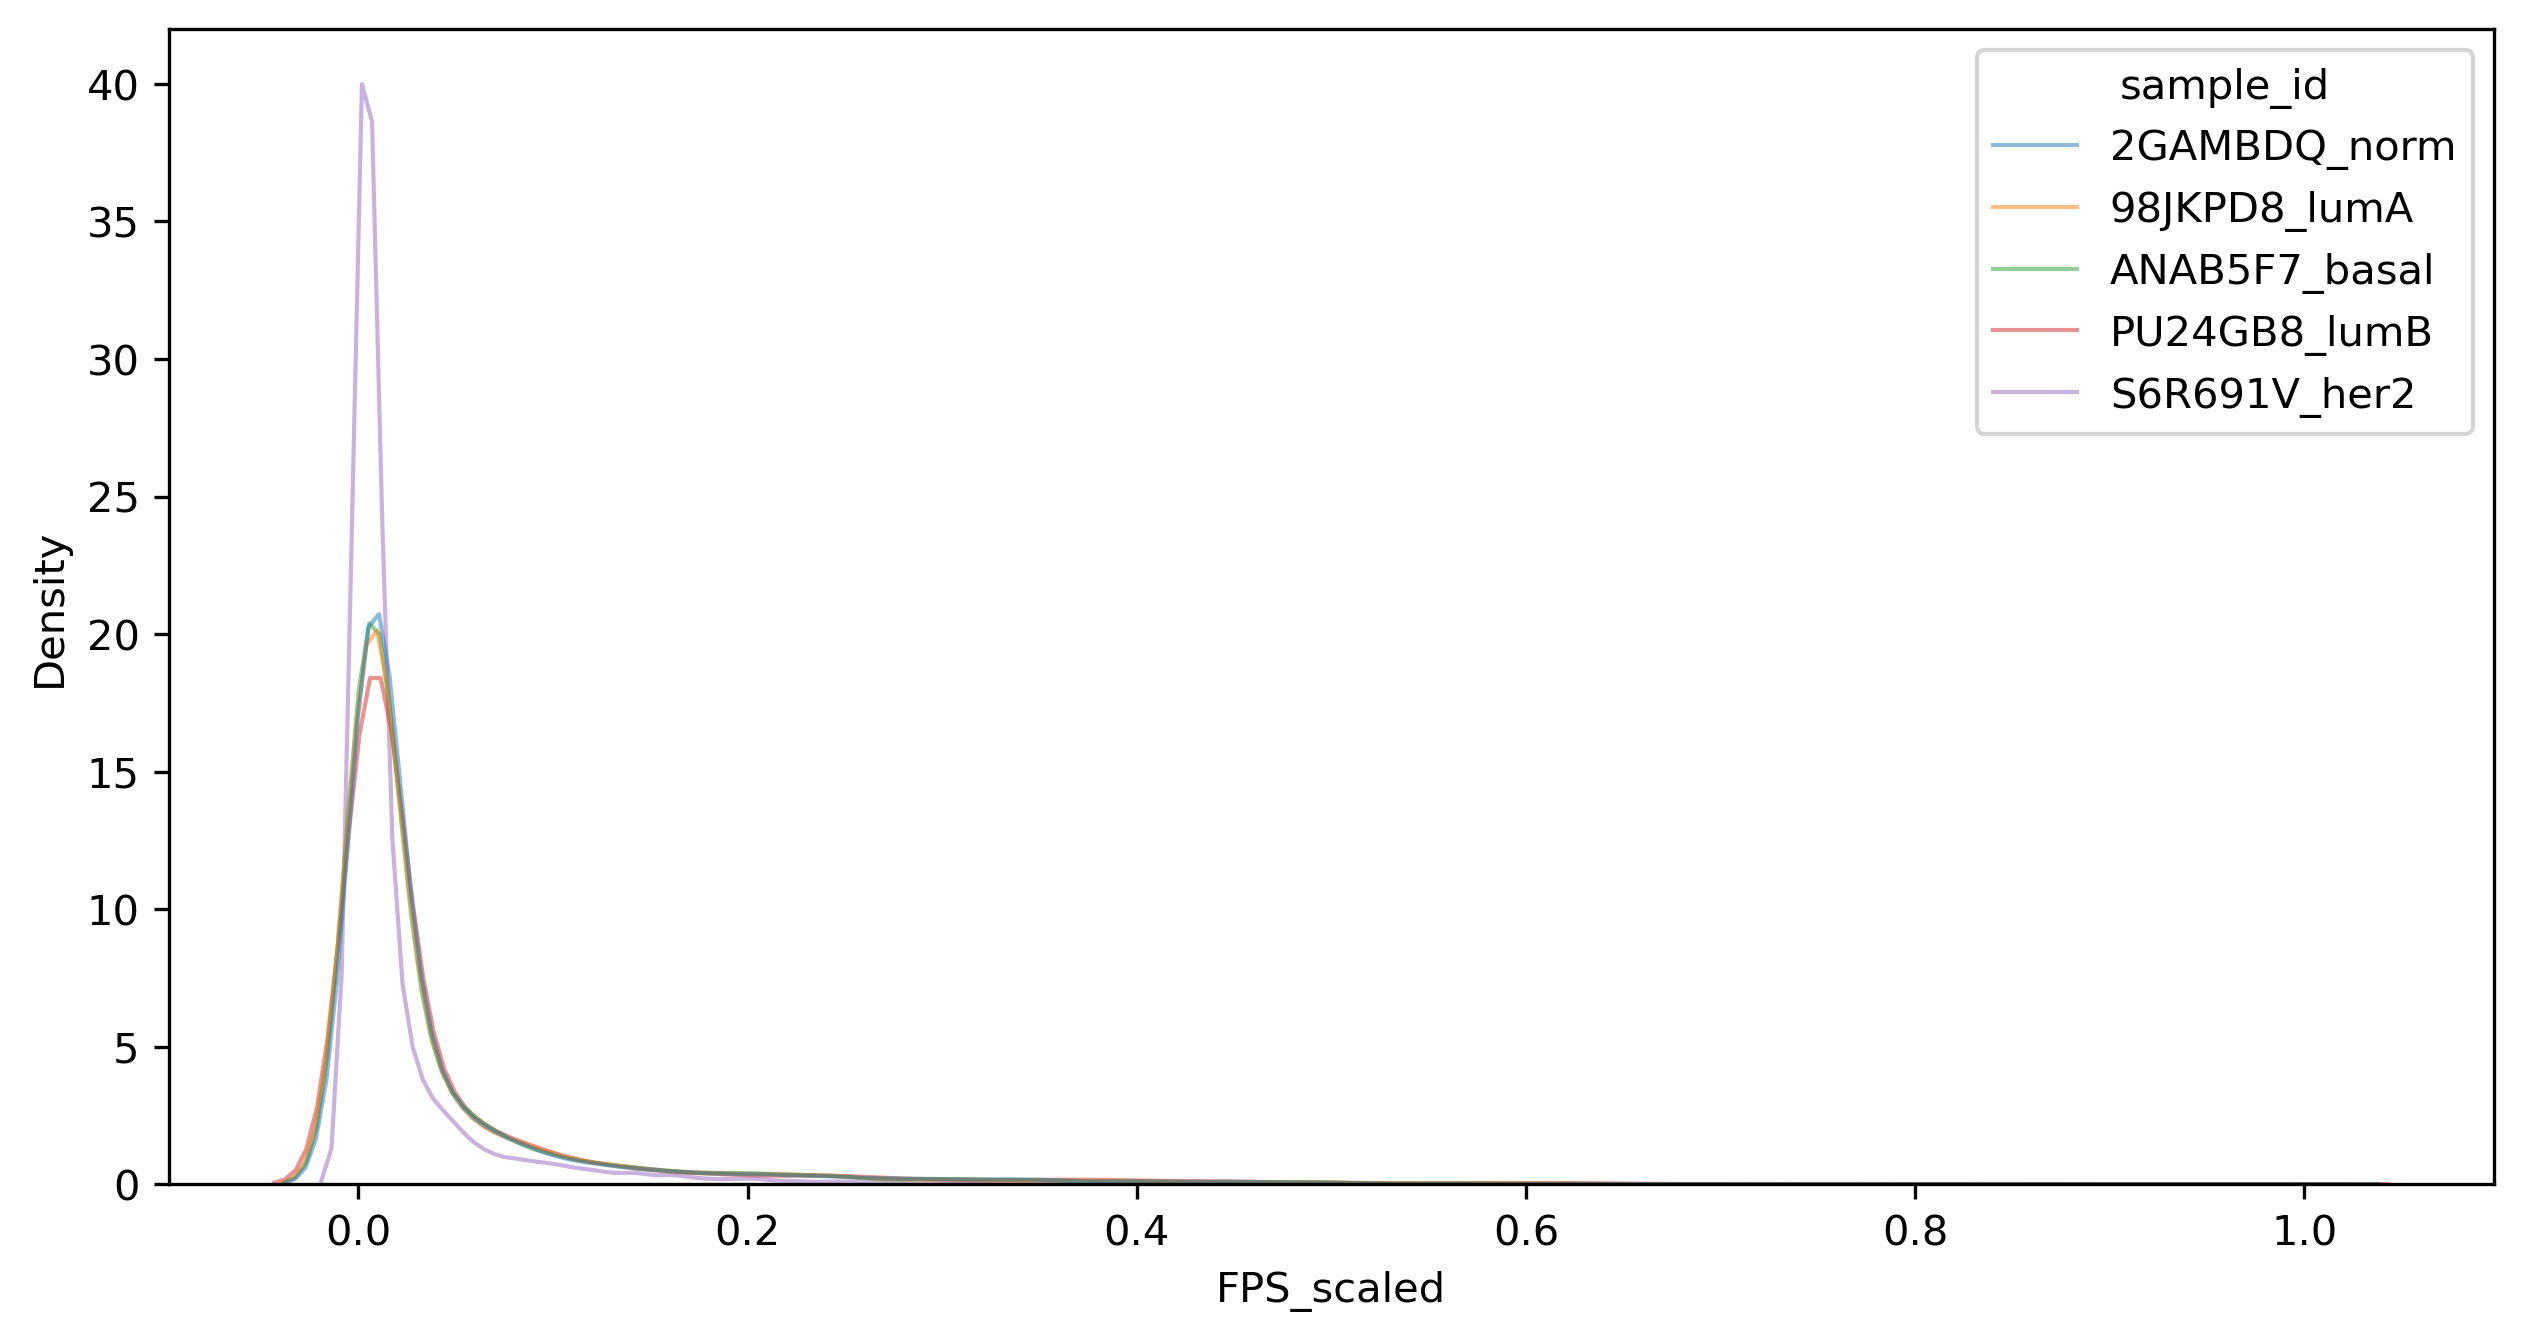

In [9]:
# plot fps distribution
plt.figure(figsize=(10, 5), dpi=300)
sns.kdeplot(data=fps_df_scaled_lpv, x="FPS_scaled", hue="sample_id", fill=False, common_norm=False, alpha=.5, linewidth=1)
plt.show()

### Merging `afps_df_lpv` and `fps_df_scaled_lpv`

Now we can merge the two long dataframes together to get both raw FPS and scaled FPS values in one dataframe.

In [11]:
afps_df_lpv

region_id      sample_id        AF  FPS
0          chr1:191257-191268   2GAMBDQ_norm  0.000000  0.0
1          chr1:191257-191268   98JKPD8_lumA  0.000000  0.0
2          chr1:191257-191268  ANAB5F7_basal  0.000000  0.0
3          chr1:191257-191268   PU24GB8_lumB  0.026316  0.0
4          chr1:191257-191268   S6R691V_her2  0.000000  0.0
...                       ...            ...       ...  ...
47795  chrY:11108019-11108030   2GAMBDQ_norm  0.437500  0.0
47796  chrY:11108019-11108030   98JKPD8_lumA  0.100000  0.0
47797  chrY:11108019-11108030  ANAB5F7_basal  0.382353  0.0
47798  chrY:11108019-11108030   PU24GB8_lumB  0.264706  0.0
47799  chrY:11108019-11108030   S6R691V_her2  0.437500  0.0

[47800 rows x 4 columns]

In [13]:
# merge two dataframes on region_id and sample_id
afps_full_dfl = afps_df_lpv.merge(fps_df_scaled_lpv, on=['region_id', 'sample_id'])
afps_full_dfl

region_id      sample_id        AF  FPS  FPS_scaled
0          chr1:191257-191268   2GAMBDQ_norm  0.000000  0.0         0.0
1          chr1:191257-191268   98JKPD8_lumA  0.000000  0.0         0.0
2          chr1:191257-191268  ANAB5F7_basal  0.000000  0.0         0.0
3          chr1:191257-191268   PU24GB8_lumB  0.026316  0.0         0.0
4          chr1:191257-191268   S6R691V_her2  0.000000  0.0         0.0
...                       ...            ...       ...  ...         ...
47795  chrY:11108019-11108030   2GAMBDQ_norm  0.437500  0.0         0.0
47796  chrY:11108019-11108030   98JKPD8_lumA  0.100000  0.0         0.0
47797  chrY:11108019-11108030  ANAB5F7_basal  0.382353  0.0         0.0
47798  chrY:11108019-11108030   PU24GB8_lumB  0.264706  0.0         0.0
47799  chrY:11108019-11108030   S6R691V_her2  0.437500  0.0         0.0

[47800 rows x 5 columns]

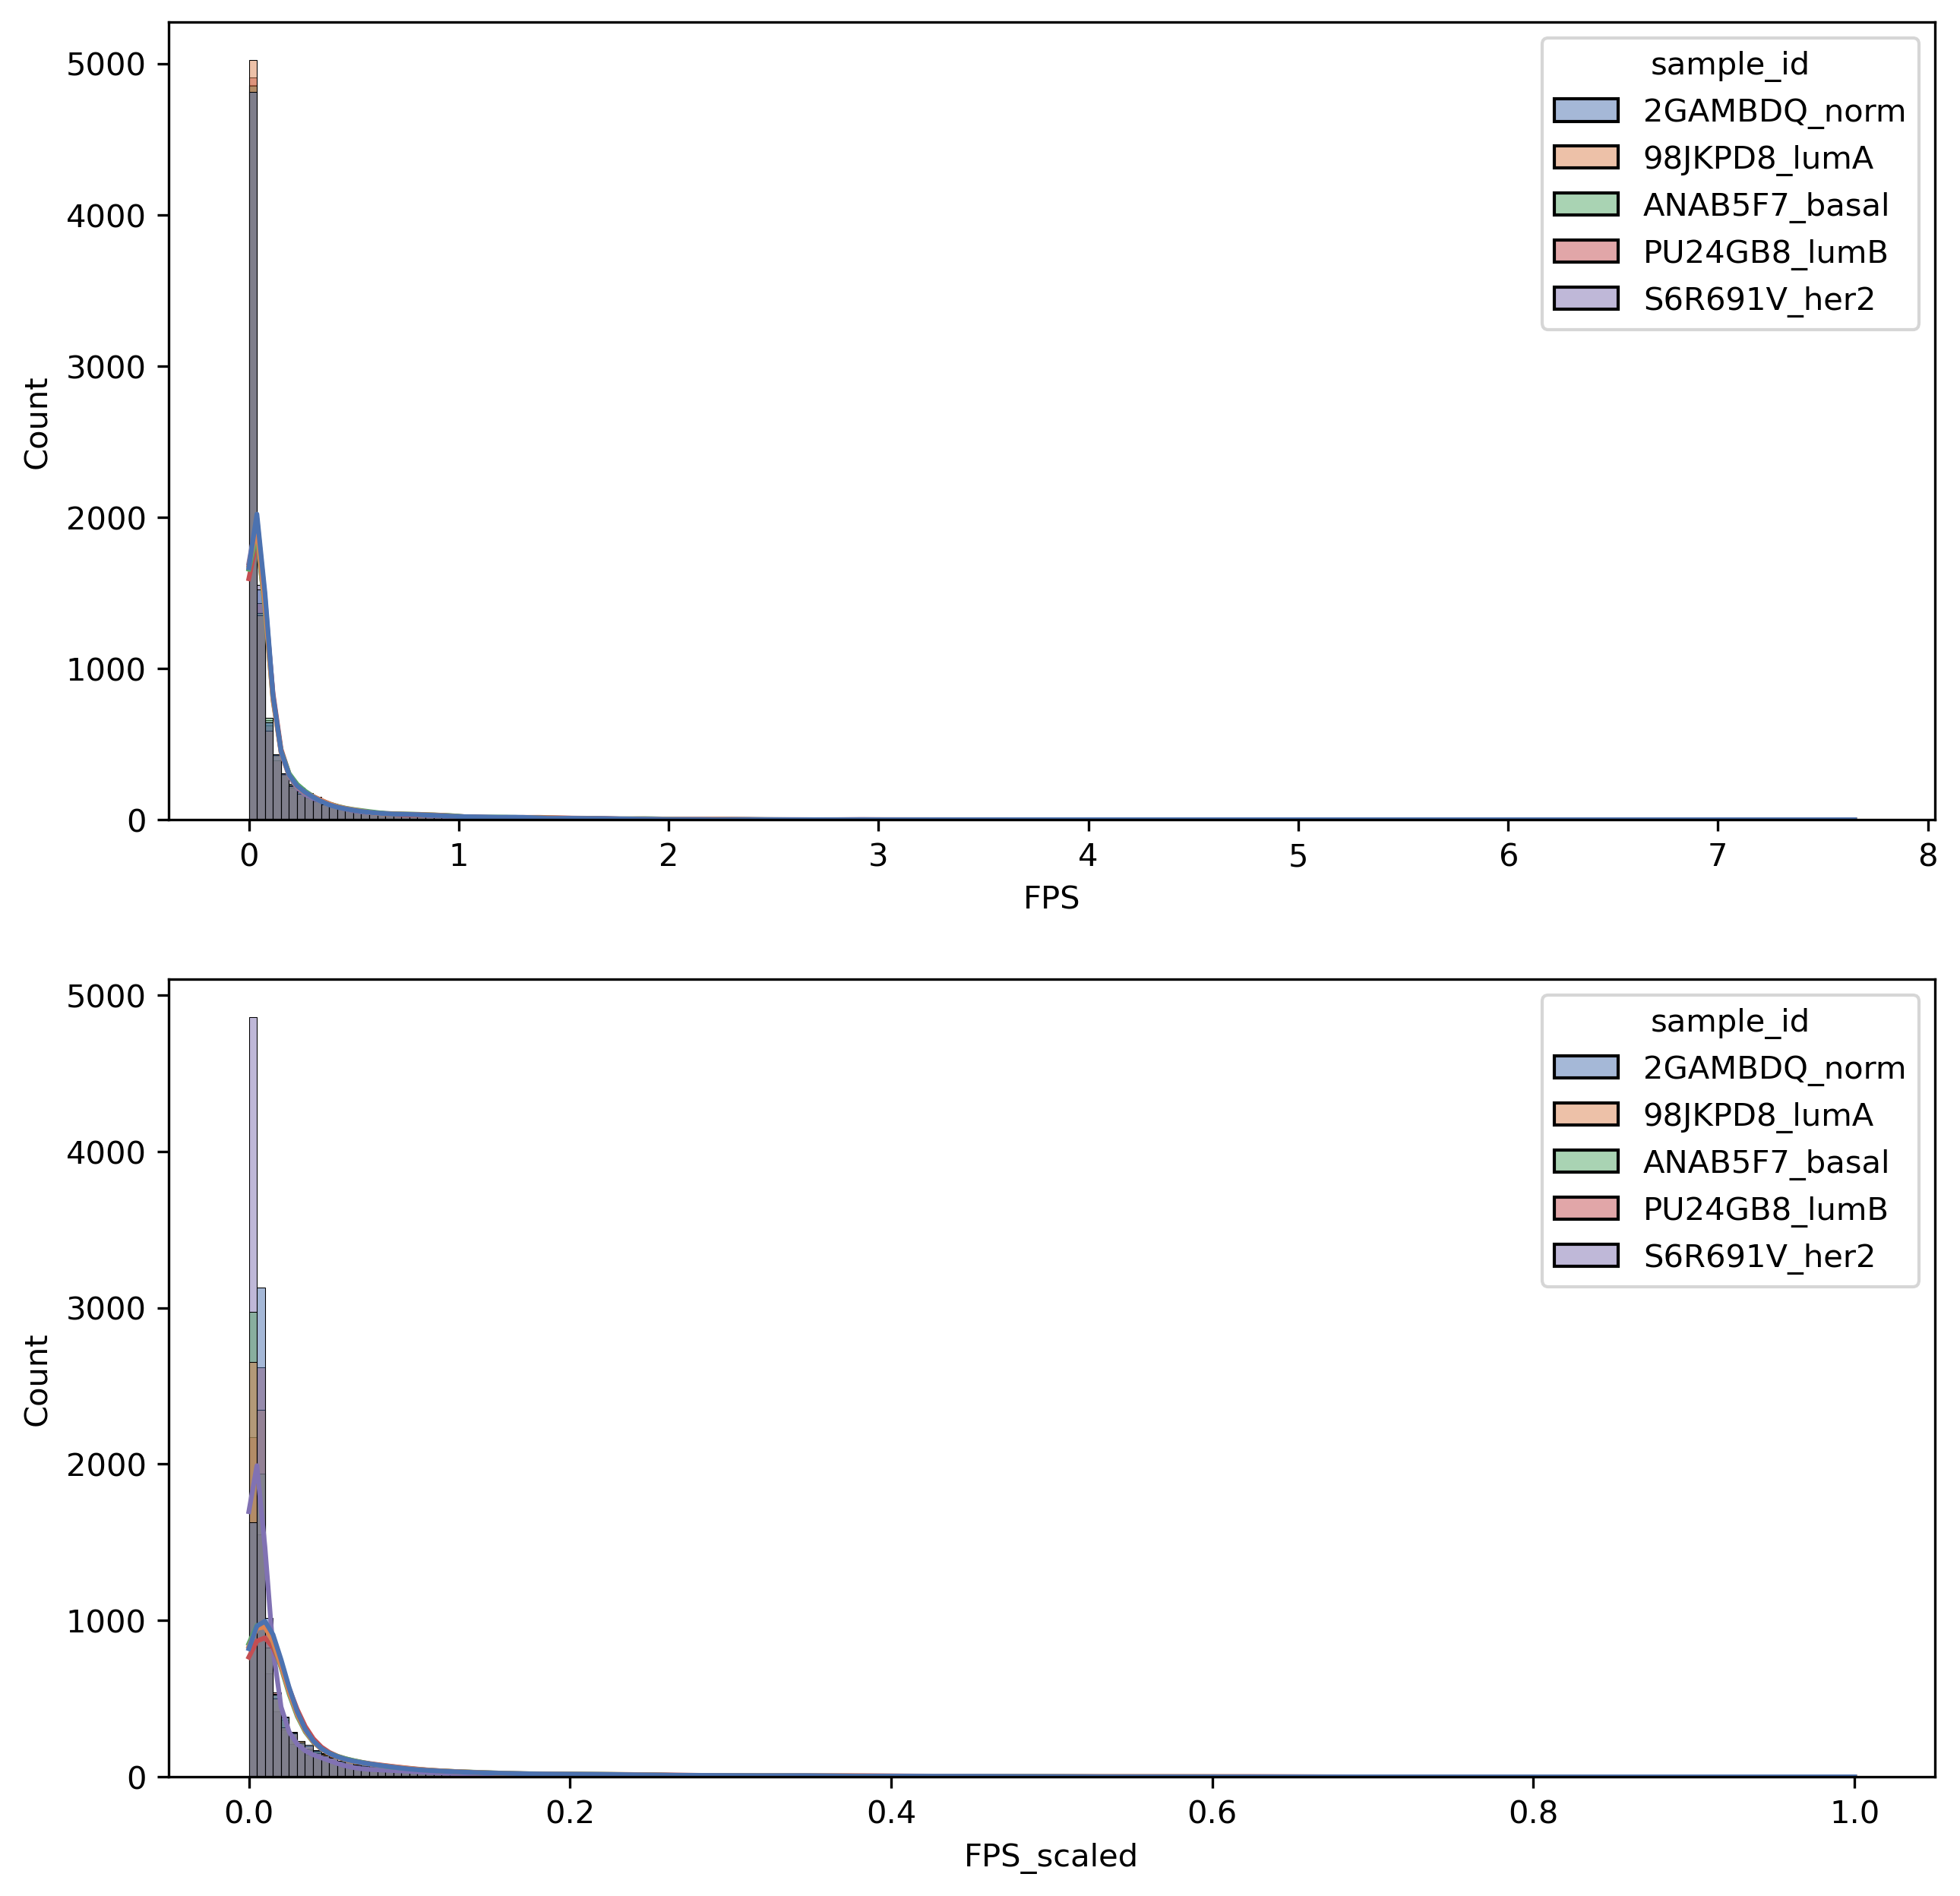

In [15]:
# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10), dpi=300)
sns.histplot(data=afps_full_dfl, x="FPS", hue="sample_id", bins=200, kde=True, palette="deep", ax=axs[0])
sns.histplot(data=afps_full_dfl, x="FPS_scaled", hue="sample_id", bins=200, kde=True, palette="deep", ax=axs[1])
# # now draw a subset plot where x is above a certain threshold
# sns.histplot(data=afps_full_dfl[afps_full_dfl['FPS'] > 0.5], x="FPS", hue="sample_id", bins=200, kde=True, palette="deep", ax=axs[2])
# plt.title(f"FPS distribution of {motif_id} in all samples")
plt.show()

Text(0.5, 0.98, 'Jointpot of AF and scaled FPS values of TFDP1_M08108_2.00')

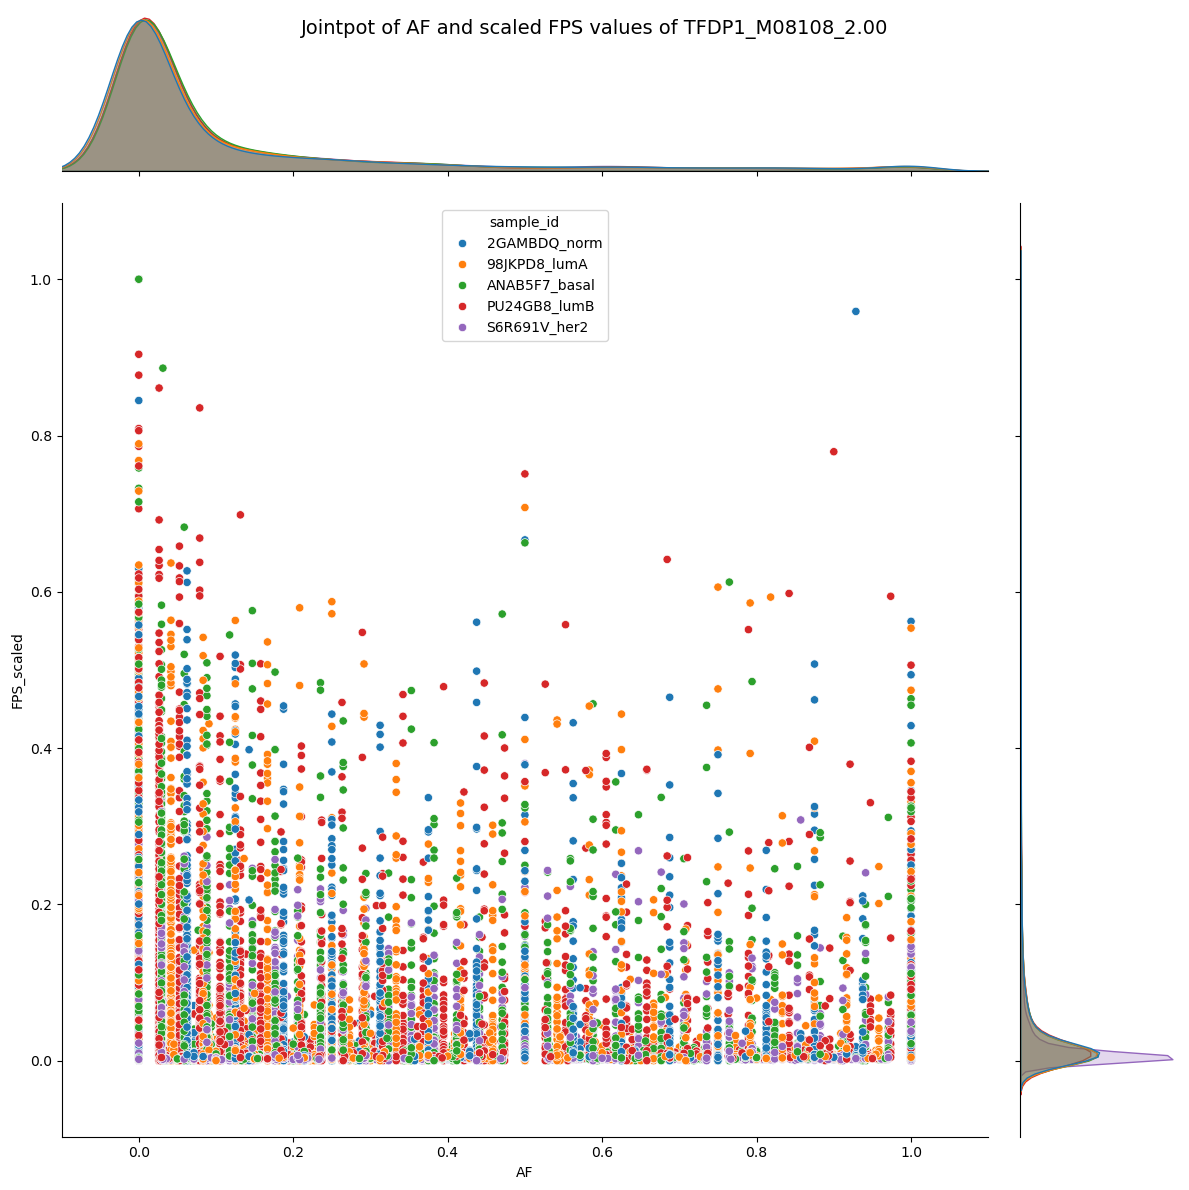

In [14]:
g = sns.jointplot(data=afps_full_dfl, x='AF', y='FPS_scaled', kind='scatter', hue='sample_id', height=12)
plt.xlim(-0.1, 1.1)
g.figure.suptitle(f"Jointpot of AF and scaled FPS values of {motif_id}", fontsize=14)

### Filtering Zero Sites

We should filter out the sites that have zero AF values in ALL subtypes, as these are not informative for our analysis. We will also filter out the sites that have zero FPS values in ALL subtypes.

In [15]:
afps_full_dfl

region_id      sample_id        AF  FPS  FPS_scaled
0          chr1:191257-191268   2GAMBDQ_norm  0.000000  0.0         0.0
1          chr1:191257-191268   98JKPD8_lumA  0.000000  0.0         0.0
2          chr1:191257-191268  ANAB5F7_basal  0.000000  0.0         0.0
3          chr1:191257-191268   PU24GB8_lumB  0.026316  0.0         0.0
4          chr1:191257-191268   S6R691V_her2  0.000000  0.0         0.0
...                       ...            ...       ...  ...         ...
47795  chrY:11108019-11108030   2GAMBDQ_norm  0.437500  0.0         0.0
47796  chrY:11108019-11108030   98JKPD8_lumA  0.100000  0.0         0.0
47797  chrY:11108019-11108030  ANAB5F7_basal  0.382353  0.0         0.0
47798  chrY:11108019-11108030   PU24GB8_lumB  0.264706  0.0         0.0
47799  chrY:11108019-11108030   S6R691V_her2  0.437500  0.0         0.0

[47800 rows x 5 columns]

`FPS` value `== 0` means that the raw FPS values across subtypes are zero, i.e. there is no evidence of footprinting at all at these sites despite a TFBS matching a motif being present (assigned by TOBIAS). AF value `== 0` means that there is no evidence of a variant genotype at these sites across the samples making up a subtype. 

In [16]:
# filter out unique region_id rows that have fps == 0 across the sample_ids and AF == 0
# group by 'region_id' first 
merged_filt_dfl = afps_full_dfl.groupby('region_id').filter(lambda x: x['FPS'].sum() > 0 and x['AF'].sum() > 0)
merged_filt_dfl

region_id      sample_id        AF      FPS  FPS_scaled
5            chr1:818021-818032   2GAMBDQ_norm  0.875000  0.03443    0.009147
6            chr1:818021-818032   98JKPD8_lumA  0.900000  0.02966    0.007823
7            chr1:818021-818032  ANAB5F7_basal  0.812500  0.04399    0.011176
8            chr1:818021-818032   PU24GB8_lumB  0.833333  0.03470    0.009443
9            chr1:818021-818032   S6R691V_her2  0.900000  0.02131    0.002785
...                         ...            ...       ...      ...         ...
47790  chrX:155641610-155641621   2GAMBDQ_norm  0.000000  0.01740    0.004623
47791  chrX:155641610-155641621   98JKPD8_lumA  0.000000  0.01249    0.003294
47792  chrX:155641610-155641621  ANAB5F7_basal  0.000000  0.01243    0.003158
47793  chrX:155641610-155641621   PU24GB8_lumB  0.029412  0.01492    0.004060
47794  chrX:155641610-155641621   S6R691V_her2  0.000000  0.01329    0.001737

[43530 rows x 5 columns]

### Calculating Variation Statistics
With the full data table cleaned up into a long format, we can now calculate the variation statistics for each region. We will calculate variance (Var).


A) First calculate statistics on the raw FPS data.

In [17]:
# extract fps columns
fps_df = dt_afps.filter(regex='_fps$|_id$').copy()
fps_df

98JKPD8_lumA_fps  ANAB5F7_basal_fps  S6R691V_her2_fps  PU24GB8_lumB_fps  \
0              0.00000            0.00000           0.00000           0.00000   
1              0.02966            0.04399           0.02131           0.03470   
2              0.02572            0.02376           0.02271           0.02814   
3              0.28046            0.33500           0.28495           0.27618   
4              1.10047            0.50514           0.71035           1.21305   
...                ...                ...               ...               ...   
9555           0.19670            0.16790           0.17212           0.19046   
9556           0.04900            0.07431           0.07307           0.09013   
9557           0.01177            0.00497           0.00875           0.01298   
9558           0.01249            0.01243           0.01329           0.01492   
9559           0.00000            0.00000           0.00000           0.00000   

      2GAMBDQ_norm_fps                 region_id  
0              0.00000        chr1:191257-191268  
1              0.03443        chr1:818021-818032  
2              0.03391        chr1:818780-818791  
3              0.22986        chr1:960570-960581  
4              1.30155        chr1:977015-977026  
...                ...                       ...  
9555           0.16161  chrX:153934861-153934872  
9556           0.04233  chrX:154444629-154444640  
9557           0.01987  chrX:155010397-155010408  
9558           0.01740  chrX:155641610-155641621  
9559           0.00000    chrY:11108019-11108030  

[9560 rows x 6 columns]

Now filter out the rows whose `region_id` is not in the `region_id` column of `merged_filt`. First, reduce the repeated `region_id` column to unique values in `merged_filt`.

In [19]:
merged_filt_uniq_region_id = merged_filt_dfl['region_id'].unique()
merged_filt_uniq_region_id


array(['chr1:818021-818032', 'chr1:818780-818791', 'chr1:960570-960581',
       ..., 'chrX:154444629-154444640', 'chrX:155010397-155010408',
       'chrX:155641610-155641621'], dtype=object)

In [20]:
# then using this array, keep only the rows in the fps_df that have `region_id` values in the array
fps_df_filt = fps_df[fps_df['region_id'].isin(merged_filt_uniq_region_id)]
fps_df_filt

98JKPD8_lumA_fps  ANAB5F7_basal_fps  S6R691V_her2_fps  PU24GB8_lumB_fps  \
1              0.02966            0.04399           0.02131           0.03470   
2              0.02572            0.02376           0.02271           0.02814   
3              0.28046            0.33500           0.28495           0.27618   
4              1.10047            0.50514           0.71035           1.21305   
5              0.88179            0.40974           0.53173           0.98628   
...                ...                ...               ...               ...   
9552           0.02192            0.03699           0.01875           0.01472   
9555           0.19670            0.16790           0.17212           0.19046   
9556           0.04900            0.07431           0.07307           0.09013   
9557           0.01177            0.00497           0.00875           0.01298   
9558           0.01249            0.01243           0.01329           0.01492   

      2GAMBDQ_norm_fps                 region_id  
1              0.03443        chr1:818021-818032  
2              0.03391        chr1:818780-818791  
3              0.22986        chr1:960570-960581  
4              1.30155        chr1:977015-977026  
5              1.07101        chr1:977047-977058  
...                ...                       ...  
9552           0.02839  chrX:153642534-153642545  
9555           0.16161  chrX:153934861-153934872  
9556           0.04233  chrX:154444629-154444640  
9557           0.01987  chrX:155010397-155010408  
9558           0.01740  chrX:155641610-155641621  

[8706 rows x 6 columns]

In [21]:
# calculate variance of fps values across samples per region_id and add to a new column called 'fps_var'
fps_df_filt_ind = fps_df_filt.set_index('region_id')
fps_df_filt_ind['FPS_var'] = fps_df_filt_ind.var(axis=1)

fps_df_filt_ind

98JKPD8_lumA_fps  ANAB5F7_basal_fps  \
region_id                                                       
chr1:818021-818032                 0.02966            0.04399   
chr1:818780-818791                 0.02572            0.02376   
chr1:960570-960581                 0.28046            0.33500   
chr1:977015-977026                 1.10047            0.50514   
chr1:977047-977058                 0.88179            0.40974   
...                                    ...                ...   
chrX:153642534-153642545           0.02192            0.03699   
chrX:153934861-153934872           0.19670            0.16790   
chrX:154444629-154444640           0.04900            0.07431   
chrX:155010397-155010408           0.01177            0.00497   
chrX:155641610-155641621           0.01249            0.01243   

                          S6R691V_her2_fps  PU24GB8_lumB_fps  \
region_id                                                      
chr1:818021-818032                 0.02131           0.03470   
chr1:818780-818791                 0.02271           0.02814   
chr1:960570-960581                 0.28495           0.27618   
chr1:977015-977026                 0.71035           1.21305   
chr1:977047-977058                 0.53173           0.98628   
...                                    ...               ...   
chrX:153642534-153642545           0.01875           0.01472   
chrX:153934861-153934872           0.17212           0.19046   
chrX:154444629-154444640           0.07307           0.09013   
chrX:155010397-155010408           0.00875           0.01298   
chrX:155641610-155641621           0.01329           0.01492   

                          2GAMBDQ_norm_fps   FPS_var  
region_id                                             
chr1:818021-818032                 0.03443  0.000068  
chr1:818780-818791                 0.03391  0.000020  
chr1:960570-960581                 0.22986  0.001393  
chr1:977015-977026                 1.30155  0.117365  
chr1:977047-977058                 1.07101  0.084064  
...                                    ...       ...  
chrX:153642534-153642545           0.02839  0.000076  
chrX:153934861-153934872           0.16161  0.000227  
chrX:154444629-154444640           0.04233  0.000388  
chrX:155010397-155010408           0.01987  0.000031  
chrX:155641610-155641621           0.01740  0.000004  

[8706 rows x 6 columns]

B) Then do the same on the fps scaled data.

Filter out the rows whose `region_id` is not in the `region_id` column of `merged_filt_scaled`.

In [25]:
fps_df_scaled

98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                     
chr1:191257-191268                       0.000000                  0.000000   
chr1:818021-818032                       0.007823                  0.011176   
chr1:818780-818791                       0.006783                  0.006036   
chr1:960570-960581                       0.073969                  0.085110   
chr1:977015-977026                       0.290240                  0.128336   
...                                           ...                       ...   
chrX:153934861-153934872                 0.051878                  0.042657   
chrX:154444629-154444640                 0.012923                  0.018879   
chrX:155010397-155010408                 0.003104                  0.001263   
chrX:155641610-155641621                 0.003294                  0.003158   
chrY:11108019-11108030                   0.000000                  0.000000   

                          S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                    
chr1:191257-191268                       0.000000                 0.000000   
chr1:818021-818032                       0.002785                 0.009443   
chr1:818780-818791                       0.002968                 0.007658   
chr1:960570-960581                       0.037244                 0.075158   
chr1:977015-977026                       0.092845                 0.330112   
...                                           ...                      ...   
chrX:153934861-153934872                 0.022497                 0.051831   
chrX:154444629-154444640                 0.009550                 0.024527   
chrX:155010397-155010408                 0.001144                 0.003532   
chrX:155641610-155641621                 0.001737                 0.004060   
chrY:11108019-11108030                   0.000000                 0.000000   

                          2GAMBDQ_norm_fps_scaled  
region_id                                          
chr1:191257-191268                       0.000000  
chr1:818021-818032                       0.009147  
chr1:818780-818791                       0.009009  
chr1:960570-960581                       0.061066  
chr1:977015-977026                       0.345779  
...                                           ...  
chrX:153934861-153934872                 0.042934  
chrX:154444629-154444640                 0.011246  
chrX:155010397-155010408                 0.005279  
chrX:155641610-155641621                 0.004623  
chrY:11108019-11108030                   0.000000  

[9560 rows x 5 columns]

In [22]:
# region_id in the scaled df is already used as index, so filter by index
fps_df_scaled_filt = fps_df_scaled[fps_df_scaled.index.isin(merged_filt_uniq_region_id)]
fps_df_scaled_filt


98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                     
chr1:818021-818032                       0.007823                  0.011176   
chr1:818780-818791                       0.006783                  0.006036   
chr1:960570-960581                       0.073969                  0.085110   
chr1:977015-977026                       0.290240                  0.128336   
chr1:977047-977058                       0.232565                  0.104098   
...                                           ...                       ...   
chrX:153642534-153642545                 0.005781                  0.009398   
chrX:153934861-153934872                 0.051878                  0.042657   
chrX:154444629-154444640                 0.012923                  0.018879   
chrX:155010397-155010408                 0.003104                  0.001263   
chrX:155641610-155641621                 0.003294                  0.003158   

                          S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                    
chr1:818021-818032                       0.002785                 0.009443   
chr1:818780-818791                       0.002968                 0.007658   
chr1:960570-960581                       0.037244                 0.075158   
chr1:977015-977026                       0.092845                 0.330112   
chr1:977047-977058                       0.069499                 0.268400   
...                                           ...                      ...   
chrX:153642534-153642545                 0.002451                 0.004006   
chrX:153934861-153934872                 0.022497                 0.051831   
chrX:154444629-154444640                 0.009550                 0.024527   
chrX:155010397-155010408                 0.001144                 0.003532   
chrX:155641610-155641621                 0.001737                 0.004060   

                          2GAMBDQ_norm_fps_scaled  
region_id                                          
chr1:818021-818032                       0.009147  
chr1:818780-818791                       0.009009  
chr1:960570-960581                       0.061066  
chr1:977015-977026                       0.345779  
chr1:977047-977058                       0.284532  
...                                           ...  
chrX:153642534-153642545                 0.007542  
chrX:153934861-153934872                 0.042934  
chrX:154444629-154444640                 0.011246  
chrX:155010397-155010408                 0.005279  
chrX:155641610-155641621                 0.004623  

[8706 rows x 5 columns]

In [23]:
# copy the slice
fps_df_scaled_filt_ind = fps_df_scaled_filt.copy()
fps_df_scaled_filt_ind

98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                     
chr1:818021-818032                       0.007823                  0.011176   
chr1:818780-818791                       0.006783                  0.006036   
chr1:960570-960581                       0.073969                  0.085110   
chr1:977015-977026                       0.290240                  0.128336   
chr1:977047-977058                       0.232565                  0.104098   
...                                           ...                       ...   
chrX:153642534-153642545                 0.005781                  0.009398   
chrX:153934861-153934872                 0.051878                  0.042657   
chrX:154444629-154444640                 0.012923                  0.018879   
chrX:155010397-155010408                 0.003104                  0.001263   
chrX:155641610-155641621                 0.003294                  0.003158   

                          S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                    
chr1:818021-818032                       0.002785                 0.009443   
chr1:818780-818791                       0.002968                 0.007658   
chr1:960570-960581                       0.037244                 0.075158   
chr1:977015-977026                       0.092845                 0.330112   
chr1:977047-977058                       0.069499                 0.268400   
...                                           ...                      ...   
chrX:153642534-153642545                 0.002451                 0.004006   
chrX:153934861-153934872                 0.022497                 0.051831   
chrX:154444629-154444640                 0.009550                 0.024527   
chrX:155010397-155010408                 0.001144                 0.003532   
chrX:155641610-155641621                 0.001737                 0.004060   

                          2GAMBDQ_norm_fps_scaled  
region_id                                          
chr1:818021-818032                       0.009147  
chr1:818780-818791                       0.009009  
chr1:960570-960581                       0.061066  
chr1:977015-977026                       0.345779  
chr1:977047-977058                       0.284532  
...                                           ...  
chrX:153642534-153642545                 0.007542  
chrX:153934861-153934872                 0.042934  
chrX:154444629-154444640                 0.011246  
chrX:155010397-155010408                 0.005279  
chrX:155641610-155641621                 0.004623  

[8706 rows x 5 columns]

In [24]:
# calculate variance of fps_scaled values across samples per region_id and add to a new column called 'fps_scaled_var'
fps_df_scaled_filt_ind['FPS_scaled_var'] = fps_df_scaled_filt_ind.var(axis=1)
fps_df_scaled_filt_ind

98JKPD8_lumA_fps_scaled  ANAB5F7_basal_fps_scaled  \
region_id                                                                     
chr1:818021-818032                       0.007823                  0.011176   
chr1:818780-818791                       0.006783                  0.006036   
chr1:960570-960581                       0.073969                  0.085110   
chr1:977015-977026                       0.290240                  0.128336   
chr1:977047-977058                       0.232565                  0.104098   
...                                           ...                       ...   
chrX:153642534-153642545                 0.005781                  0.009398   
chrX:153934861-153934872                 0.051878                  0.042657   
chrX:154444629-154444640                 0.012923                  0.018879   
chrX:155010397-155010408                 0.003104                  0.001263   
chrX:155641610-155641621                 0.003294                  0.003158   

                          S6R691V_her2_fps_scaled  PU24GB8_lumB_fps_scaled  \
region_id                                                                    
chr1:818021-818032                       0.002785                 0.009443   
chr1:818780-818791                       0.002968                 0.007658   
chr1:960570-960581                       0.037244                 0.075158   
chr1:977015-977026                       0.092845                 0.330112   
chr1:977047-977058                       0.069499                 0.268400   
...                                           ...                      ...   
chrX:153642534-153642545                 0.002451                 0.004006   
chrX:153934861-153934872                 0.022497                 0.051831   
chrX:154444629-154444640                 0.009550                 0.024527   
chrX:155010397-155010408                 0.001144                 0.003532   
chrX:155641610-155641621                 0.001737                 0.004060   

                          2GAMBDQ_norm_fps_scaled  FPS_scaled_var  
region_id                                                          
chr1:818021-818032                       0.009147        0.000010  
chr1:818780-818791                       0.009009        0.000005  
chr1:960570-960581                       0.061066        0.000341  
chr1:977015-977026                       0.345779        0.013981  
chr1:977047-977058                       0.284532        0.009694  
...                                           ...             ...  
chrX:153642534-153642545                 0.007542        0.000008  
chrX:153934861-153934872                 0.042934        0.000144  
chrX:154444629-154444640                 0.011246        0.000038  
chrX:155010397-155010408                 0.005279        0.000003  
chrX:155641610-155641621                 0.004623        0.000001  

[8706 rows x 6 columns]

C) Now do the same for the AF data.

In [25]:
# Do the same for AF values
# extract af columns
af_df = dt_afps.filter(regex='_AF$|_id$')
af_df


2GAMBDQ_norm_AF  98JKPD8_lumA_AF  ANAB5F7_basal_AF  PU24GB8_lumB_AF  \
0            0.000000         0.000000          0.000000         0.026316   
1            0.875000         0.900000          0.812500         0.833333   
2            0.000000         0.125000          0.033333         0.055556   
3            0.000000         0.041667          0.000000         0.000000   
4            1.000000         1.000000          0.941176         0.947368   
...               ...              ...               ...              ...   
9555         0.062500         0.000000          0.000000         0.000000   
9556         0.000000         0.125000          0.058824         0.105263   
9557         0.083333         0.312500          0.000000         0.392857   
9558         0.000000         0.000000          0.000000         0.029412   
9559         0.437500         0.100000          0.382353         0.264706   

      S6R691V_her2_AF                 region_id  
0            0.000000        chr1:191257-191268  
1            0.900000        chr1:818021-818032  
2            0.062500        chr1:818780-818791  
3            0.000000        chr1:960570-960581  
4            0.911765        chr1:977015-977026  
...               ...                       ...  
9555         0.000000  chrX:153934861-153934872  
9556         0.000000  chrX:154444629-154444640  
9557         0.100000  chrX:155010397-155010408  
9558         0.000000  chrX:155641610-155641621  
9559         0.437500    chrY:11108019-11108030  

[9560 rows x 6 columns]

In [26]:
# filter by region_id
af_df_filt = af_df[af_df['region_id'].isin(merged_filt_uniq_region_id)]
af_df_filt

2GAMBDQ_norm_AF  98JKPD8_lumA_AF  ANAB5F7_basal_AF  PU24GB8_lumB_AF  \
1            0.875000         0.900000          0.812500         0.833333   
2            0.000000         0.125000          0.033333         0.055556   
3            0.000000         0.041667          0.000000         0.000000   
4            1.000000         1.000000          0.941176         0.947368   
5            0.750000         1.000000          0.500000         0.789474   
...               ...              ...               ...              ...   
9552         0.062500         0.000000          0.000000         0.000000   
9555         0.062500         0.000000          0.000000         0.000000   
9556         0.000000         0.125000          0.058824         0.105263   
9557         0.083333         0.312500          0.000000         0.392857   
9558         0.000000         0.000000          0.000000         0.029412   

      S6R691V_her2_AF                 region_id  
1            0.900000        chr1:818021-818032  
2            0.062500        chr1:818780-818791  
3            0.000000        chr1:960570-960581  
4            0.911765        chr1:977015-977026  
5            0.588235        chr1:977047-977058  
...               ...                       ...  
9552         0.000000  chrX:153642534-153642545  
9555         0.000000  chrX:153934861-153934872  
9556         0.000000  chrX:154444629-154444640  
9557         0.100000  chrX:155010397-155010408  
9558         0.000000  chrX:155641610-155641621  

[8706 rows x 6 columns]

In [27]:
af_df_filt_ind = af_df_filt.set_index('region_id')
# then calculate variance of af values across samples per region_id and add to a new column called 'af_var'
af_df_filt_ind['AF_var'] = af_df_filt_ind.var(axis=1)
af_df_filt_ind

2GAMBDQ_norm_AF  98JKPD8_lumA_AF  ANAB5F7_basal_AF  \
region_id                                                                      
chr1:818021-818032               0.875000         0.900000          0.812500   
chr1:818780-818791               0.000000         0.125000          0.033333   
chr1:960570-960581               0.000000         0.041667          0.000000   
chr1:977015-977026               1.000000         1.000000          0.941176   
chr1:977047-977058               0.750000         1.000000          0.500000   
...                                   ...              ...               ...   
chrX:153642534-153642545         0.062500         0.000000          0.000000   
chrX:153934861-153934872         0.062500         0.000000          0.000000   
chrX:154444629-154444640         0.000000         0.125000          0.058824   
chrX:155010397-155010408         0.083333         0.312500          0.000000   
chrX:155641610-155641621         0.000000         0.000000          0.000000   

                          PU24GB8_lumB_AF  S6R691V_her2_AF    AF_var  
region_id                                                             
chr1:818021-818032               0.833333         0.900000  0.001576  
chr1:818780-818791               0.055556         0.062500  0.002113  
chr1:960570-960581               0.000000         0.000000  0.000347  
chr1:977015-977026               0.947368         0.911765  0.001510  
chr1:977047-977058               0.789474         0.588235  0.037434  
...                                   ...              ...       ...  
chrX:153642534-153642545         0.000000         0.000000  0.000781  
chrX:153934861-153934872         0.000000         0.000000  0.000781  
chrX:154444629-154444640         0.105263         0.000000  0.003363  
chrX:155010397-155010408         0.392857         0.100000  0.027746  
chrX:155641610-155641621         0.029412         0.000000  0.000173  

[8706 rows x 6 columns]

D) Now merge the statistics tables together on `region_id` index.

In [28]:
fps_filt_var = fps_df_filt_ind.filter(regex='_var$|_id$').copy()
fps_filt_var

FPS_var
region_id                         
chr1:818021-818032        0.000068
chr1:818780-818791        0.000020
chr1:960570-960581        0.001393
chr1:977015-977026        0.117365
chr1:977047-977058        0.084064
...                            ...
chrX:153642534-153642545  0.000076
chrX:153934861-153934872  0.000227
chrX:154444629-154444640  0.000388
chrX:155010397-155010408  0.000031
chrX:155641610-155641621  0.000004

[8706 rows x 1 columns]

In [29]:
fps_sc_filt_var = fps_df_scaled_filt_ind.filter(regex='_var$|_id$').copy()
af_filt_var = af_df_filt_ind.filter(regex='_var$|_id$').copy()
# merge on region_id index from both tables
merged_var_tmp = fps_filt_var.merge(fps_sc_filt_var, left_index=True, right_index=True)
# now merge with af_df
merged_var = merged_var_tmp.merge(af_filt_var, left_index=True, right_index=True)
merged_var

FPS_var  FPS_scaled_var    AF_var
region_id                                                   
chr1:818021-818032        0.000068        0.000010  0.001576
chr1:818780-818791        0.000020        0.000005  0.002113
chr1:960570-960581        0.001393        0.000341  0.000347
chr1:977015-977026        0.117365        0.013981  0.001510
chr1:977047-977058        0.084064        0.009694  0.037434
...                            ...             ...       ...
chrX:153642534-153642545  0.000076        0.000008  0.000781
chrX:153934861-153934872  0.000227        0.000144  0.000781
chrX:154444629-154444640  0.000388        0.000038  0.003363
chrX:155010397-155010408  0.000031        0.000003  0.027746
chrX:155641610-155641621  0.000004        0.000001  0.000173

[8706 rows x 3 columns]

Now we have a table of stats data to merge with the `merge_filt` raw data.

In [30]:
# set the index to 'region_id'
merged_filt_i = merged_filt_dfl.set_index('region_id')
merged_filt_i

sample_id        AF      FPS  FPS_scaled
region_id                                                             
chr1:818021-818032         2GAMBDQ_norm  0.875000  0.03443    0.009147
chr1:818021-818032         98JKPD8_lumA  0.900000  0.02966    0.007823
chr1:818021-818032        ANAB5F7_basal  0.812500  0.04399    0.011176
chr1:818021-818032         PU24GB8_lumB  0.833333  0.03470    0.009443
chr1:818021-818032         S6R691V_her2  0.900000  0.02131    0.002785
...                                 ...       ...      ...         ...
chrX:155641610-155641621   2GAMBDQ_norm  0.000000  0.01740    0.004623
chrX:155641610-155641621   98JKPD8_lumA  0.000000  0.01249    0.003294
chrX:155641610-155641621  ANAB5F7_basal  0.000000  0.01243    0.003158
chrX:155641610-155641621   PU24GB8_lumB  0.029412  0.01492    0.004060
chrX:155641610-155641621   S6R691V_her2  0.000000  0.01329    0.001737

[43530 rows x 4 columns]

In [31]:
# merge afps_full_dfli with stats df on region_id
merged_stat = merged_filt_i.merge(merged_var, left_index=True, right_index=True, how='left')
merged_stat


sample_id        AF      FPS  FPS_scaled  \
region_id                                                                
chr1:818021-818032         2GAMBDQ_norm  0.875000  0.03443    0.009147   
chr1:818021-818032         98JKPD8_lumA  0.900000  0.02966    0.007823   
chr1:818021-818032        ANAB5F7_basal  0.812500  0.04399    0.011176   
chr1:818021-818032         PU24GB8_lumB  0.833333  0.03470    0.009443   
chr1:818021-818032         S6R691V_her2  0.900000  0.02131    0.002785   
...                                 ...       ...      ...         ...   
chrX:155641610-155641621   2GAMBDQ_norm  0.000000  0.01740    0.004623   
chrX:155641610-155641621   98JKPD8_lumA  0.000000  0.01249    0.003294   
chrX:155641610-155641621  ANAB5F7_basal  0.000000  0.01243    0.003158   
chrX:155641610-155641621   PU24GB8_lumB  0.029412  0.01492    0.004060   
chrX:155641610-155641621   S6R691V_her2  0.000000  0.01329    0.001737   

                           FPS_var  FPS_scaled_var    AF_var  
region_id                                                     
chr1:818021-818032        0.000068        0.000010  0.001576  
chr1:818021-818032        0.000068        0.000010  0.001576  
chr1:818021-818032        0.000068        0.000010  0.001576  
chr1:818021-818032        0.000068        0.000010  0.001576  
chr1:818021-818032        0.000068        0.000010  0.001576  
...                            ...             ...       ...  
chrX:155641610-155641621  0.000004        0.000001  0.000173  
chrX:155641610-155641621  0.000004        0.000001  0.000173  
chrX:155641610-155641621  0.000004        0.000001  0.000173  
chrX:155641610-155641621  0.000004        0.000001  0.000173  
chrX:155641610-155641621  0.000004        0.000001  0.000173  

[43530 rows x 7 columns]

In [42]:
# drop the FPS and FPS_var columns
merged_stat = merged_stat.drop(columns=merged_stat.filter(regex='FPS_var|FPS$').columns)
merged_stat

sample_id        AF  FPS_scaled  FPS_scaled_var  \
region_id                                                                       
chr1:818021-818032         2GAMBDQ_norm  0.875000    0.009147        0.000010   
chr1:818021-818032         98JKPD8_lumA  0.900000    0.007823        0.000010   
chr1:818021-818032        ANAB5F7_basal  0.812500    0.011176        0.000010   
chr1:818021-818032         PU24GB8_lumB  0.833333    0.009443        0.000010   
chr1:818021-818032         S6R691V_her2  0.900000    0.002785        0.000010   
...                                 ...       ...         ...             ...   
chrX:155641610-155641621   2GAMBDQ_norm  0.000000    0.004623        0.000001   
chrX:155641610-155641621   98JKPD8_lumA  0.000000    0.003294        0.000001   
chrX:155641610-155641621  ANAB5F7_basal  0.000000    0.003158        0.000001   
chrX:155641610-155641621   PU24GB8_lumB  0.029412    0.004060        0.000001   
chrX:155641610-155641621   S6R691V_her2  0.000000    0.001737        0.000001   

                            AF_var  
region_id                           
chr1:818021-818032        0.001576  
chr1:818021-818032        0.001576  
chr1:818021-818032        0.001576  
chr1:818021-818032        0.001576  
chr1:818021-818032        0.001576  
...                            ...  
chrX:155641610-155641621  0.000173  
chrX:155641610-155641621  0.000173  
chrX:155641610-155641621  0.000173  
chrX:155641610-155641621  0.000173  
chrX:155641610-155641621  0.000173  

[43530 rows x 5 columns]

In [32]:
# rearrange columns
merged_stat = merged_stat[['sample_id', 'AF', 'FPS_scaled', 'AF_var', 'FPS_scaled_var']]
merged_stat

sample_id        AF  FPS_scaled    AF_var  \
region_id                                                                 
chr1:818021-818032         2GAMBDQ_norm  0.875000    0.009147  0.001576   
chr1:818021-818032         98JKPD8_lumA  0.900000    0.007823  0.001576   
chr1:818021-818032        ANAB5F7_basal  0.812500    0.011176  0.001576   
chr1:818021-818032         PU24GB8_lumB  0.833333    0.009443  0.001576   
chr1:818021-818032         S6R691V_her2  0.900000    0.002785  0.001576   
...                                 ...       ...         ...       ...   
chrX:155641610-155641621   2GAMBDQ_norm  0.000000    0.004623  0.000173   
chrX:155641610-155641621   98JKPD8_lumA  0.000000    0.003294  0.000173   
chrX:155641610-155641621  ANAB5F7_basal  0.000000    0.003158  0.000173   
chrX:155641610-155641621   PU24GB8_lumB  0.029412    0.004060  0.000173   
chrX:155641610-155641621   S6R691V_her2  0.000000    0.001737  0.000173   

                          FPS_scaled_var  
region_id                                 
chr1:818021-818032              0.000010  
chr1:818021-818032              0.000010  
chr1:818021-818032              0.000010  
chr1:818021-818032              0.000010  
chr1:818021-818032              0.000010  
...                                  ...  
chrX:155641610-155641621        0.000001  
chrX:155641610-155641621        0.000001  
chrX:155641610-155641621        0.000001  
chrX:155641610-155641621        0.000001  
chrX:155641610-155641621        0.000001  

[43530 rows x 5 columns]

#### ASIDE: Visualizing `AF_var` and `FPS_scaled_var`
We can now see if there is a correlation between the variance of the AF and FPS values, per `region_id`. As the statistics are calculated per `region_id`, we can plot the `FPS_scaled_var` and `AF_var` values against each other.

In [33]:
# subset a copy of the dataframe with only the AF_var and FPS_scaled_var columns and region_id
merged_stat_corrplot = merged_stat[['AF_var', 'FPS_scaled_var']].copy().drop_duplicates()
merged_stat_corrplot

AF_var  FPS_scaled_var
region_id                                         
chr1:818021-818032        0.001576        0.000010
chr1:818780-818791        0.002113        0.000005
chr1:960570-960581        0.000347        0.000341
chr1:977015-977026        0.001510        0.013981
chr1:977047-977058        0.037434        0.009694
...                            ...             ...
chrX:153642534-153642545  0.000781        0.000008
chrX:153934861-153934872  0.000781        0.000144
chrX:154444629-154444640  0.003363        0.000038
chrX:155010397-155010408  0.027746        0.000003
chrX:155641610-155641621  0.000173        0.000001

[8706 rows x 2 columns]

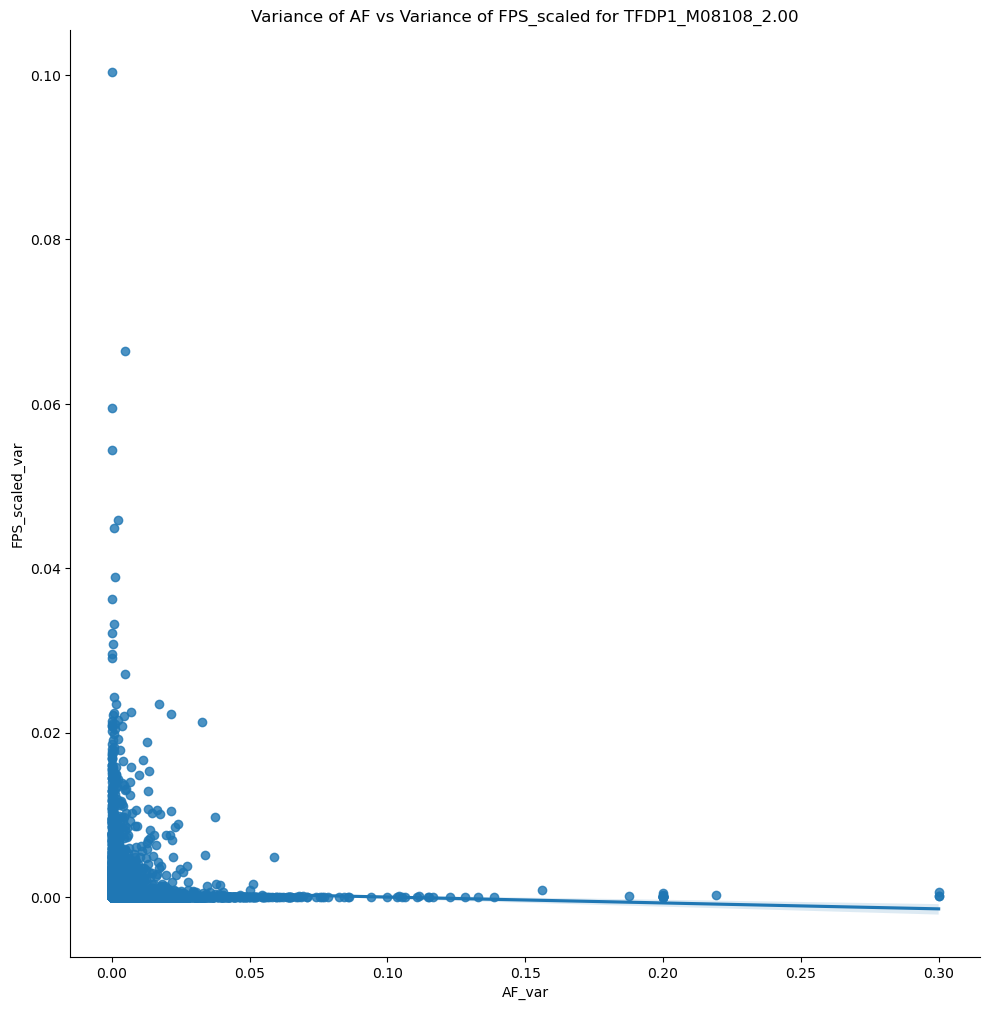

In [34]:
# plot lmplot
sns.lmplot(data=merged_stat_corrplot, x='AF_var', y='FPS_scaled_var', fit_reg=True, height=10)
plt.title(f'Variance of AF vs Variance of FPS_scaled for {motif_id}')
plt.show()

### Finding Covariant Sites 

Now that `merged_stat` contains the variance statistics for both AF and FPS values, we can find the sites that have high variance in both AF and FPS values. We can do this by filtering the `merged_stat` table to include only the rows where both `AF_var` and `FPS_scaled_var` are above a certain threshold.

To remove arbitrariness, IQR outlier method can be used to find the threshold for high variance.

In [35]:
merged_stat

sample_id        AF  FPS_scaled    AF_var  \
region_id                                                                 
chr1:818021-818032         2GAMBDQ_norm  0.875000    0.009147  0.001576   
chr1:818021-818032         98JKPD8_lumA  0.900000    0.007823  0.001576   
chr1:818021-818032        ANAB5F7_basal  0.812500    0.011176  0.001576   
chr1:818021-818032         PU24GB8_lumB  0.833333    0.009443  0.001576   
chr1:818021-818032         S6R691V_her2  0.900000    0.002785  0.001576   
...                                 ...       ...         ...       ...   
chrX:155641610-155641621   2GAMBDQ_norm  0.000000    0.004623  0.000173   
chrX:155641610-155641621   98JKPD8_lumA  0.000000    0.003294  0.000173   
chrX:155641610-155641621  ANAB5F7_basal  0.000000    0.003158  0.000173   
chrX:155641610-155641621   PU24GB8_lumB  0.029412    0.004060  0.000173   
chrX:155641610-155641621   S6R691V_her2  0.000000    0.001737  0.000173   

                          FPS_scaled_var  
region_id                                 
chr1:818021-818032              0.000010  
chr1:818021-818032              0.000010  
chr1:818021-818032              0.000010  
chr1:818021-818032              0.000010  
chr1:818021-818032              0.000010  
...                                  ...  
chrX:155641610-155641621        0.000001  
chrX:155641610-155641621        0.000001  
chrX:155641610-155641621        0.000001  
chrX:155641610-155641621        0.000001  
chrX:155641610-155641621        0.000001  

[43530 rows x 5 columns]

In [37]:
# subset the dataframe to only include the AF_var and FPS_scaled_var columns and keep only unique rows
merged_stat_vars = merged_stat[['AF_var', 'FPS_scaled_var']].copy().drop_duplicates()
merged_stat_vars

AF_var  FPS_scaled_var
region_id                                         
chr1:818021-818032        0.001576        0.000010
chr1:818780-818791        0.002113        0.000005
chr1:960570-960581        0.000347        0.000341
chr1:977015-977026        0.001510        0.013981
chr1:977047-977058        0.037434        0.009694
...                            ...             ...
chrX:153642534-153642545  0.000781        0.000008
chrX:153934861-153934872  0.000781        0.000144
chrX:154444629-154444640  0.003363        0.000038
chrX:155010397-155010408  0.027746        0.000003
chrX:155641610-155641621  0.000173        0.000001

[8706 rows x 2 columns]

We can plot boxplots to visualize the distribution of `AF_var` and `FPS_scaled_var` values.

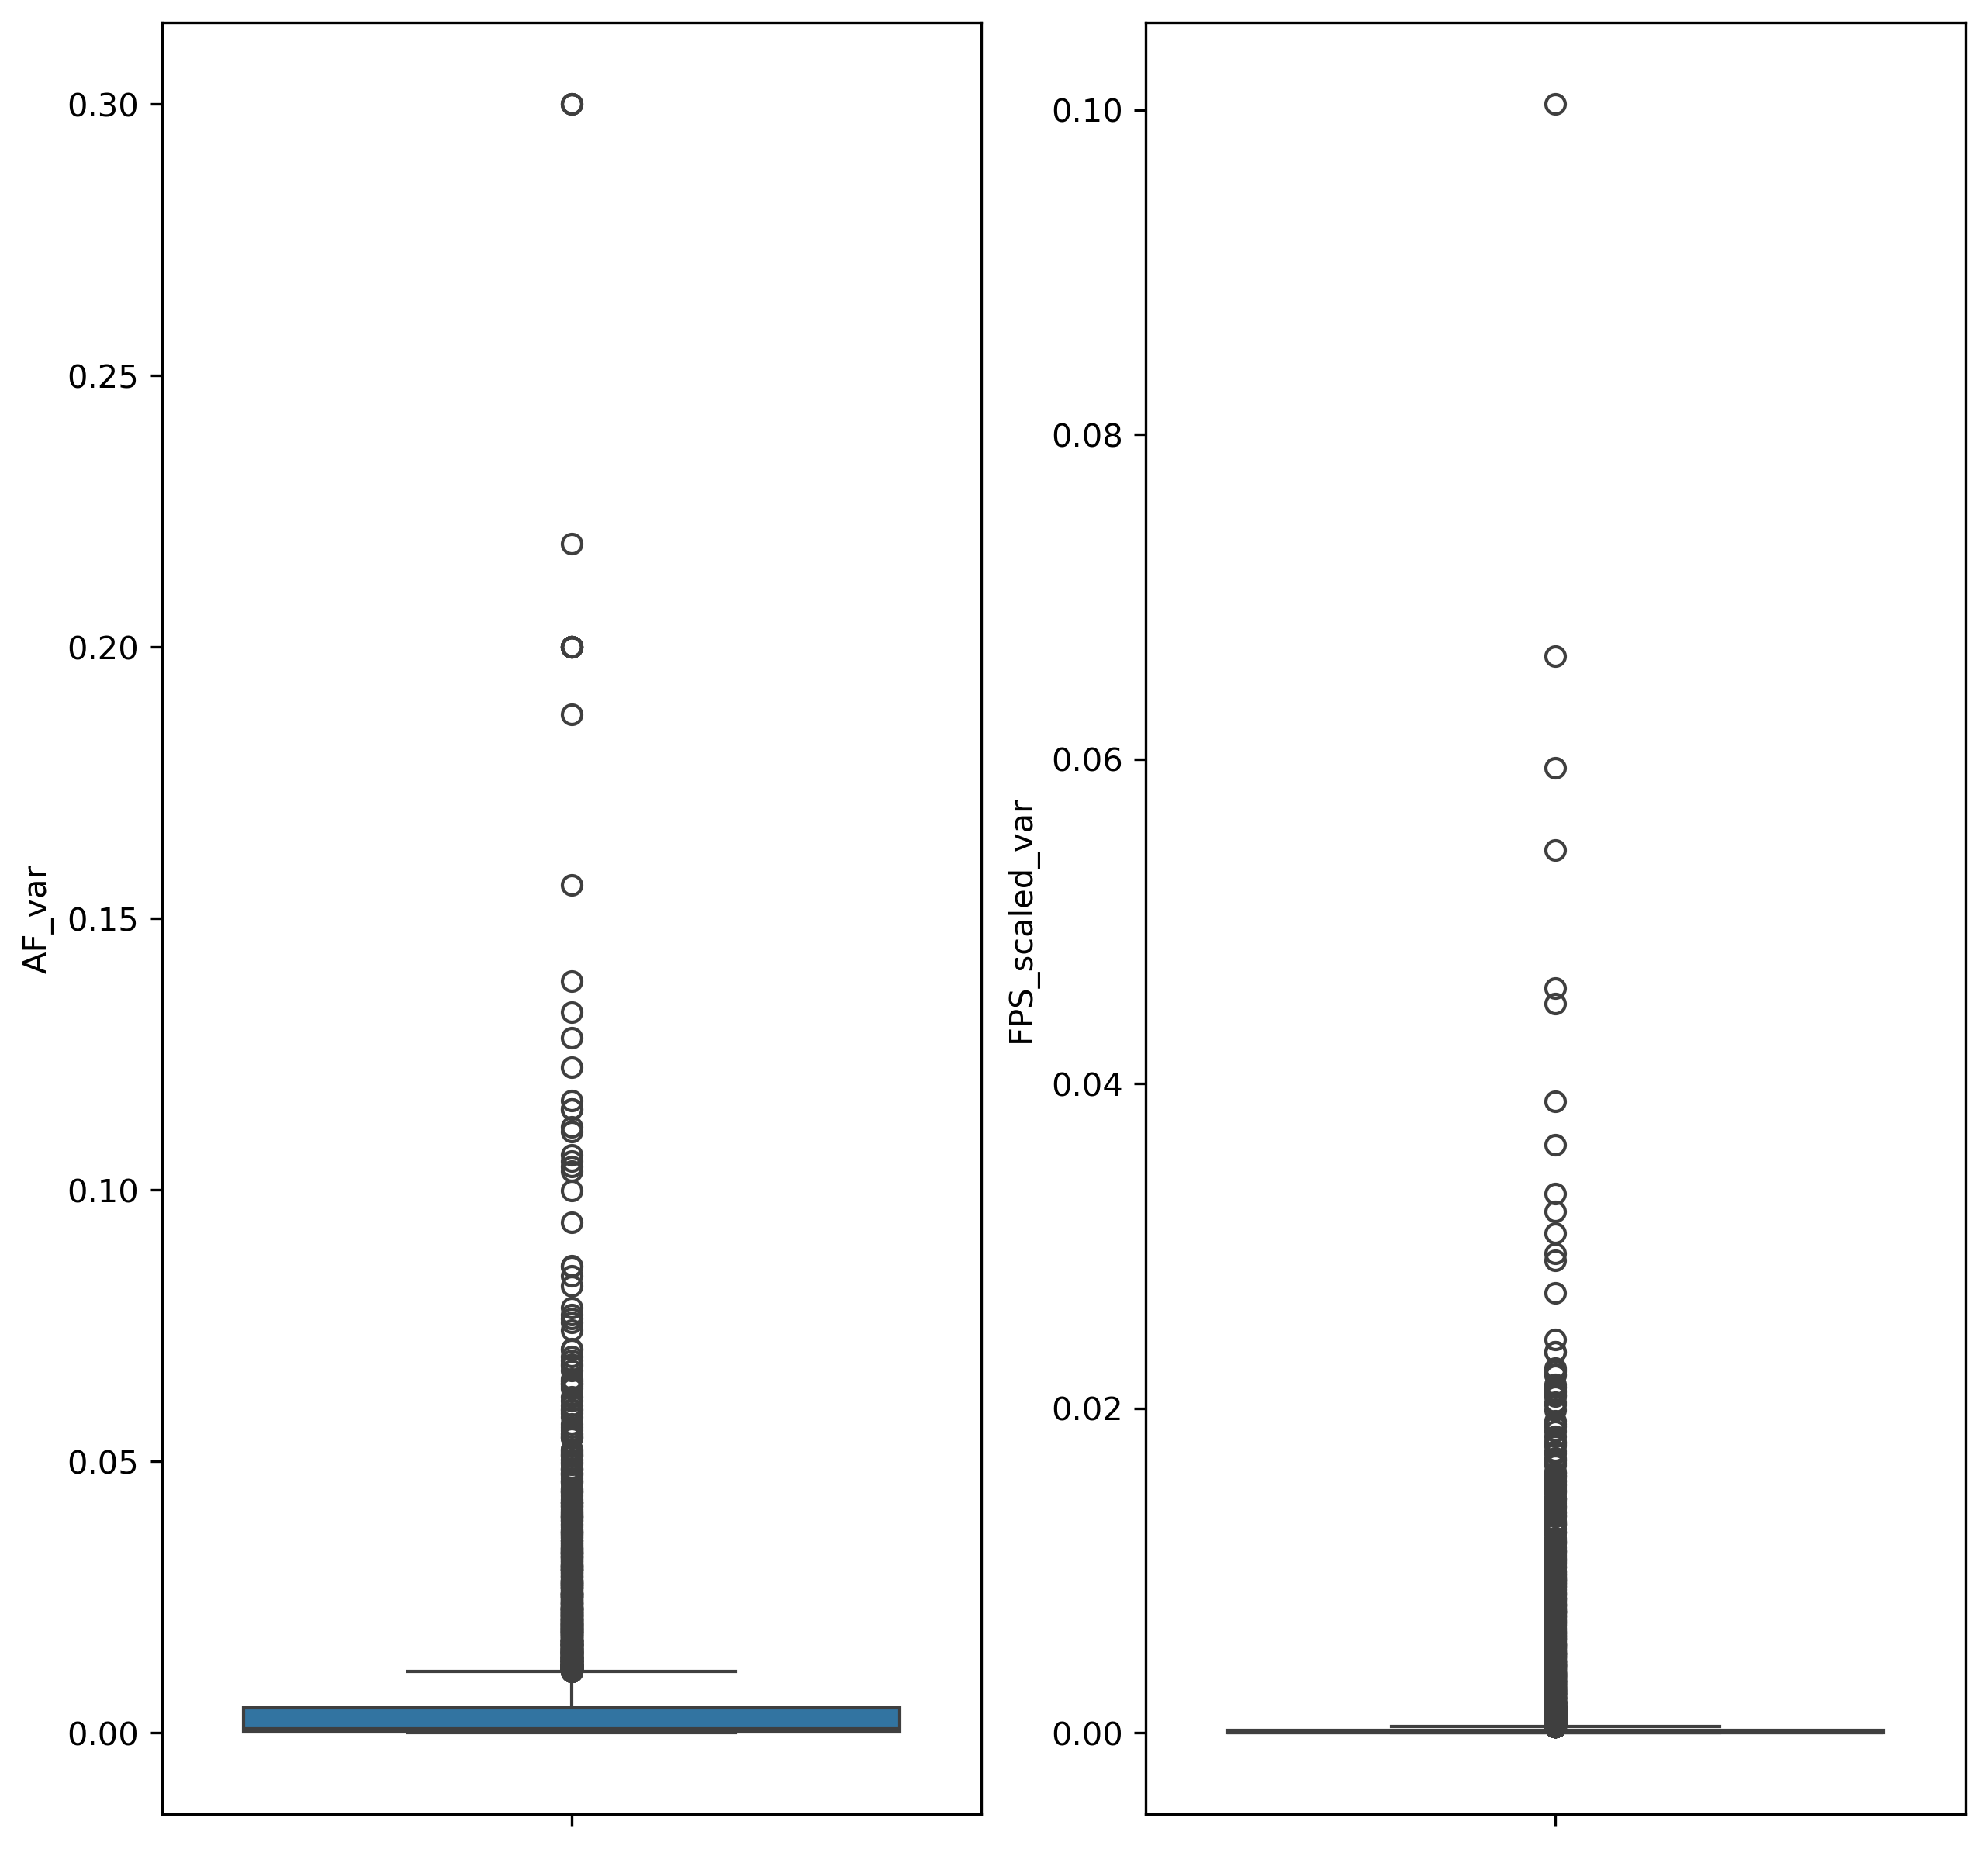

In [38]:
# plot bloxplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300)
sns.boxplot(data=merged_stat_vars, y='AF_var', ax=axs[0])
sns.boxplot(data=merged_stat_vars, y='FPS_scaled_var', ax=axs[1])
plt.show()

The distribution is highly skewed and we are looking at variances, not raw data points, so we can probably ignore the lower bounds and just use the upper bounds as the threshold to filter for potentially interesting sites. 




Calculate the distribution of `AF_var` and `FPS_scaled_var` values and then calculate the IQR for each. Then, calculate the upper and lower bounds for the `AF_var` and `FPS_scaled_var` values.

In [39]:
# Calculate the IQR for AF_var and FPS_scaled_var separately

q1_vaf = merged_stat_vars['AF_var'].quantile(0.25)
q3_vaf = merged_stat_vars['AF_var'].quantile(0.75)
iqr_vaf = q3_vaf - q1_vaf
lower_bound_outliers_vaf = q1_vaf - (1.5 * iqr_vaf)
upper_bound_outliers_vaf = q3_vaf + (1.5 * iqr_vaf)

# calculate IQR for FPS_scaled_var
q1_vfps = merged_stat_vars['FPS_scaled_var'].quantile(0.25)
q3_vfps = merged_stat_vars['FPS_scaled_var'].quantile(0.75)
iqr_vfps = q3_vfps - q1_vfps
lower_bound_outliers_vfps = q1_vfps - (1.5 * iqr_vfps)
upper_bound_outliers_vfps = q3_vfps + (1.5 * iqr_vfps)

print(f'Outlier bounds for {motif_id} AF variance: {lower_bound_outliers_vaf, upper_bound_outliers_vaf}')

print(f'Outlier bounds for {motif_id} FPS_scaled variance: {lower_bound_outliers_vfps, upper_bound_outliers_vfps}')

Outlier bounds for TFDP1_M08108_2.00 AF variance: (-0.006431253983107125, 0.011311348045919874)
Outlier bounds for TFDP1_M08108_2.00 FPS_scaled variance: (-0.00022509123785722238, 0.0003832948356750625)


In [40]:
# using the outlier fence of upper bound, get the region_id that are outliers for both AF_var and FPS_scaled_var
outlier_af_fps_vars = merged_stat_vars[(merged_stat_vars['AF_var'] > upper_bound_outliers_vaf) & (merged_stat_vars['FPS_scaled_var'] > upper_bound_outliers_vfps)]

outlier_af_fps_vars

AF_var  FPS_scaled_var
region_id                                         
chr1:977047-977058        0.037434        0.009694
chr1:977174-977185        0.200000        0.000478
chr1:977206-977217        0.156171        0.000789
chr1:977394-977405        0.300000        0.000556
chr1:3857731-3857742      0.014514        0.000814
...                            ...             ...
chr22:39520618-39520629   0.014366        0.000983
chr22:42369353-42369364   0.015027        0.005037
chr22:50474997-50475008   0.037910        0.001630
chrX:24054420-24054431    0.011948        0.000549
chrX:119606547-119606558  0.011720        0.000570

[118 rows x 2 columns]

In [41]:
# now extract the unique region IDs as a list from the outlier_af_fps_vars
outliers_list = outlier_af_fps_vars.index.tolist()

# subset the merged_stat dataframe to get the highly covariant sites (outlier sites)
covar_sites = merged_stat[merged_stat.index.isin(outliers_list)]

covar_sites

sample_id        AF  FPS_scaled    AF_var  \
region_id                                                                 
chr1:977047-977058         2GAMBDQ_norm  0.750000    0.284532  0.037434   
chr1:977047-977058         98JKPD8_lumA  1.000000    0.232565  0.037434   
chr1:977047-977058        ANAB5F7_basal  0.500000    0.104098  0.037434   
chr1:977047-977058         PU24GB8_lumB  0.789474    0.268400  0.037434   
chr1:977047-977058         S6R691V_her2  0.588235    0.069499  0.037434   
...                                 ...       ...         ...       ...   
chrX:119606547-119606558   2GAMBDQ_norm  0.750000    0.094577  0.011720   
chrX:119606547-119606558   98JKPD8_lumA  0.666667    0.111742  0.011720   
chrX:119606547-119606558  ANAB5F7_basal  0.941176    0.108128  0.011720   
chrX:119606547-119606558   PU24GB8_lumB  0.710526    0.117186  0.011720   
chrX:119606547-119606558   S6R691V_her2  0.705882    0.057896  0.011720   

                          FPS_scaled_var  
region_id                                 
chr1:977047-977058              0.009694  
chr1:977047-977058              0.009694  
chr1:977047-977058              0.009694  
chr1:977047-977058              0.009694  
chr1:977047-977058              0.009694  
...                                  ...  
chrX:119606547-119606558        0.000570  
chrX:119606547-119606558        0.000570  
chrX:119606547-119606558        0.000570  
chrX:119606547-119606558        0.000570  
chrX:119606547-119606558        0.000570  

[590 rows x 5 columns]

In [43]:
# sort the outlier sites by descending order of AF_var and FPS_scaled_var
covar_sites_sorted = covar_sites.sort_values(by=['AF_var', 'FPS_scaled_var'], ascending=[False, False])

We can plot to see the distributions.

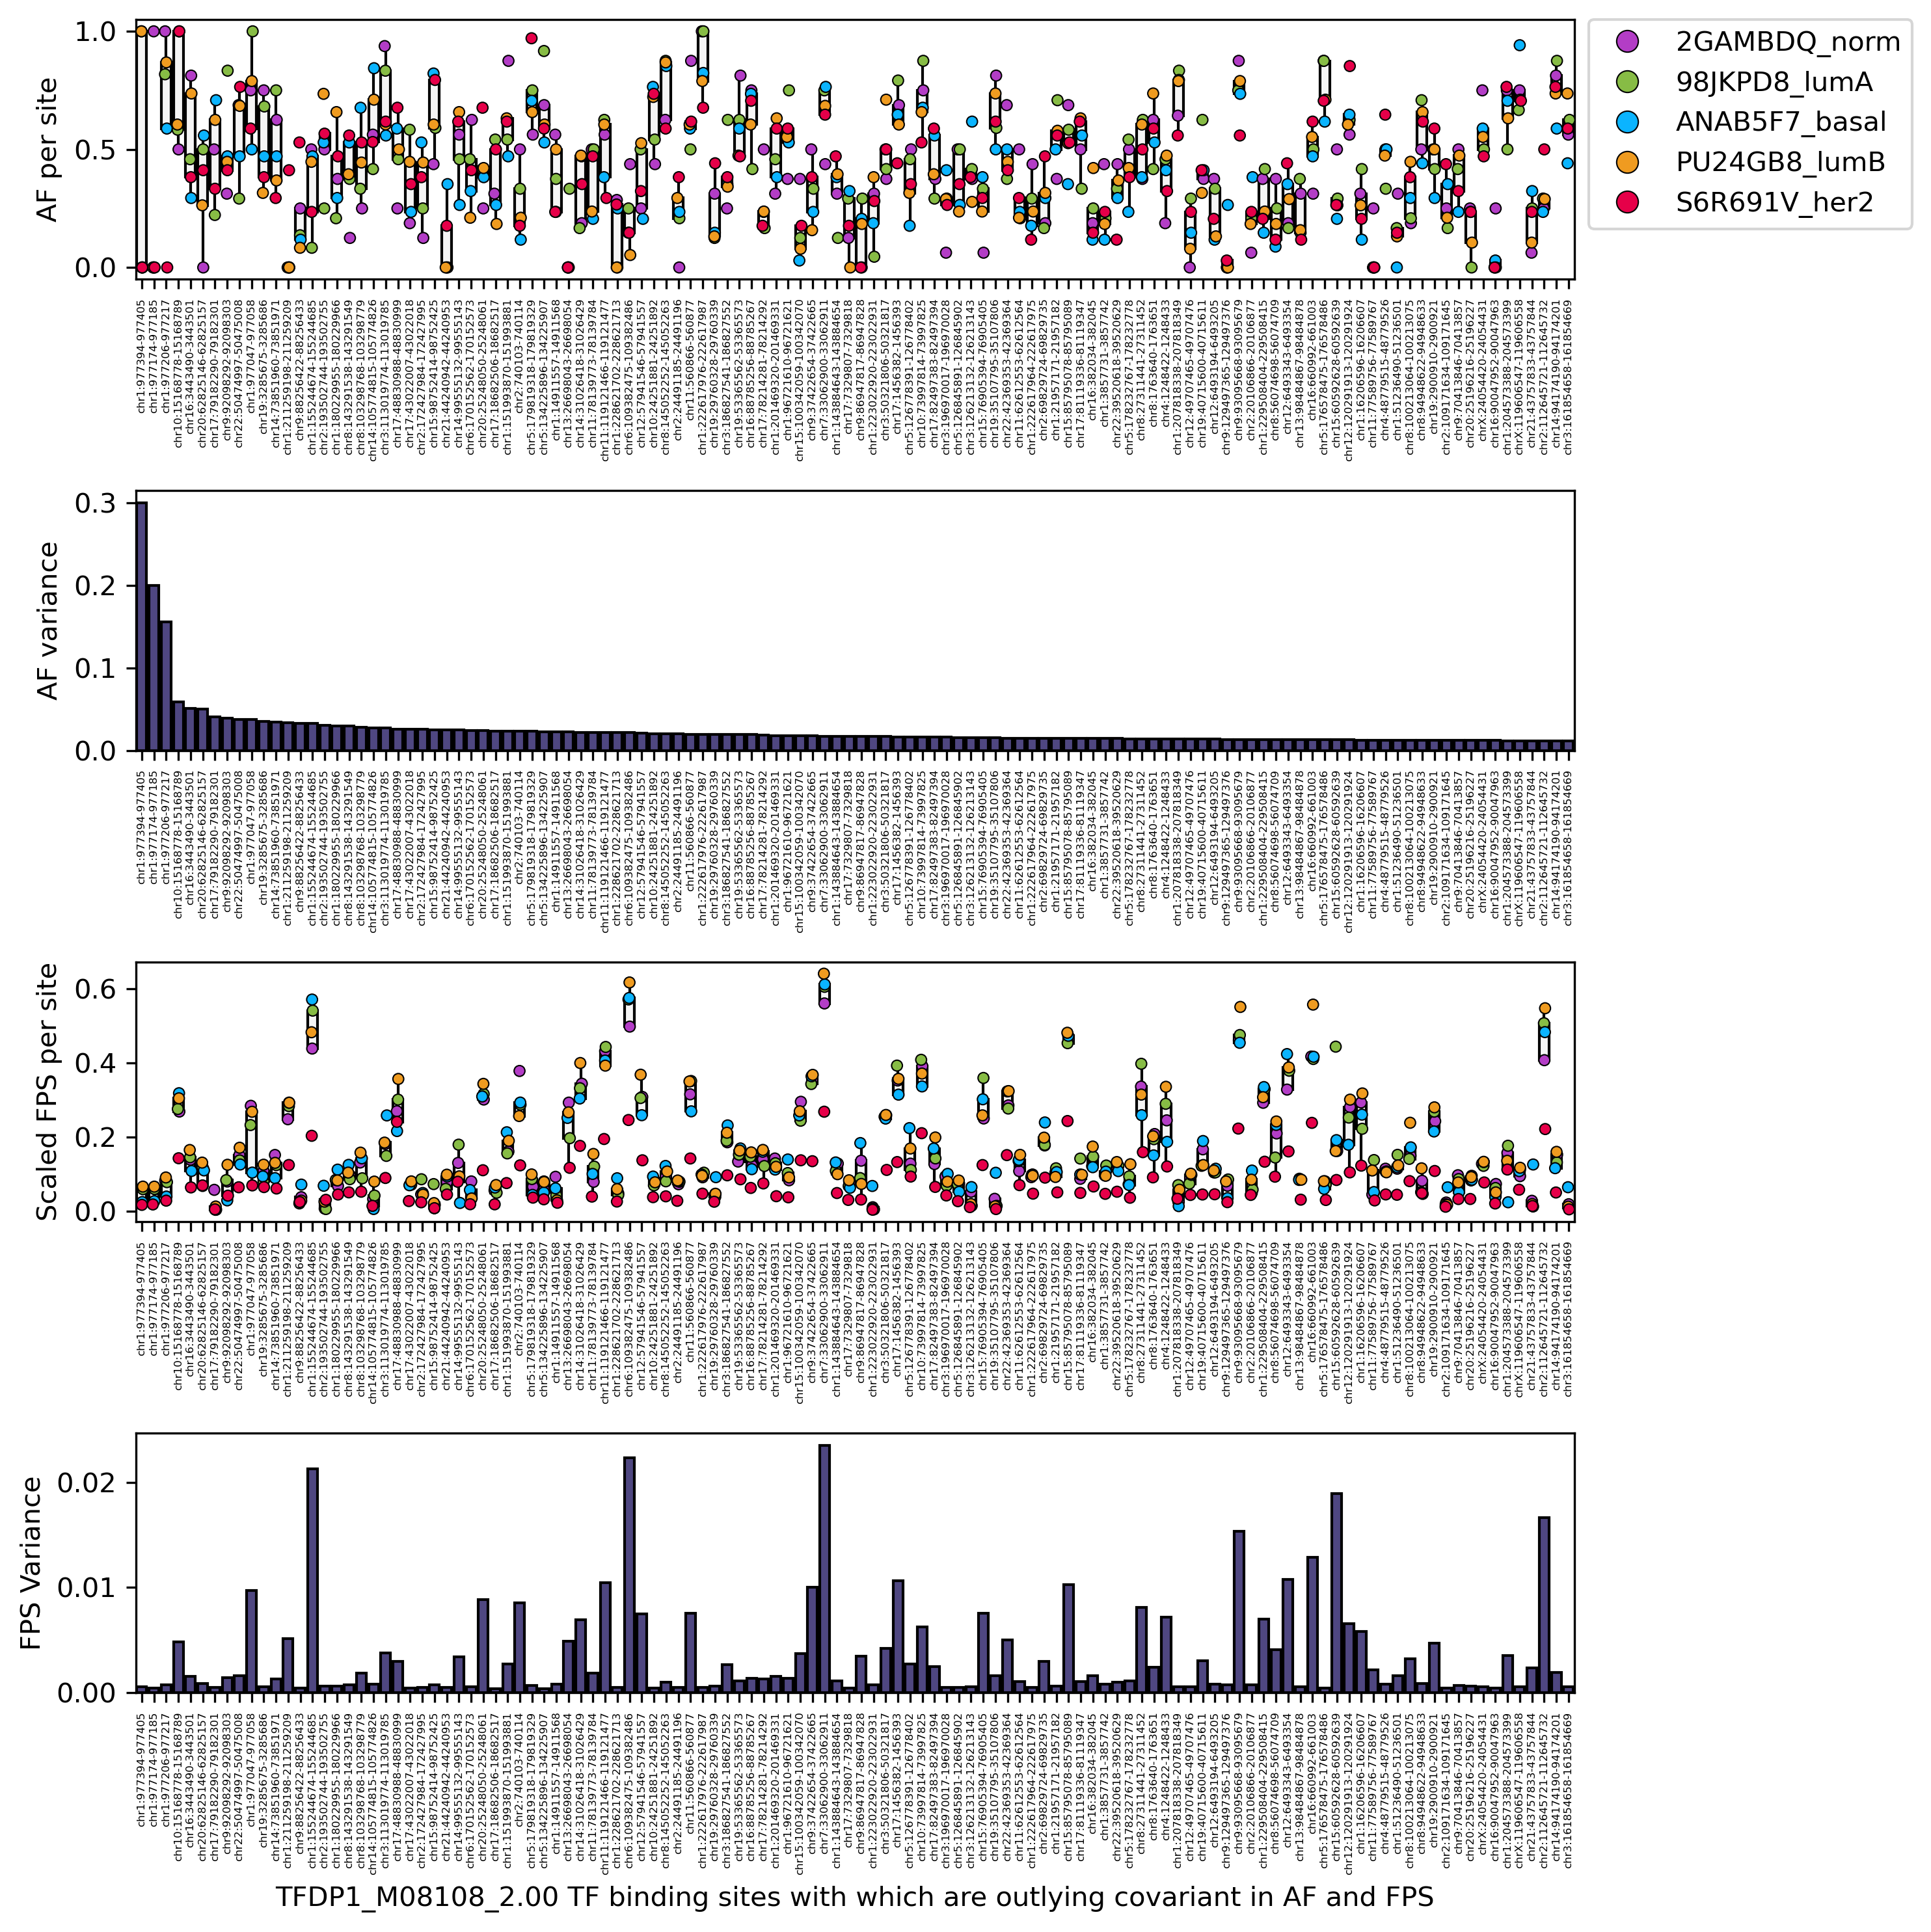

In [44]:
# create color dictionary
dutchfield_colordict = {'S6R691V_her2': "#e60049", 'ANAB5F7_basal': "#0bb4ff", '98JKPD8_lumA': "#87bc45", 'PU24GB8_lumB': "#ef9b20", '2GAMBDQ_norm': "#b33dc6"}
plt.figure(figsize=(10, 10), dpi=300)
# specify subplot
plt.subplot(4, 1, 1)
sns.boxplot(x='region_id', y='AF', data=covar_sites_sorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='AF', data=covar_sites_sorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, linewidth=0.5, edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
plt.ylabel('AF per site', fontsize=10)
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, markerscale=2, fontsize=10)

plt.subplot(4, 1, 2)
sns.barplot(x='region_id', y='AF_var', data=covar_sites_sorted, color='darkslateblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
plt.ylabel('AF variance', fontsize=10)
  
plt.subplot(4, 1, 3)
sns.boxplot(x='region_id', y='FPS_scaled', data=covar_sites_sorted, color='whitesmoke', linecolor='black', showfliers=False)
sns.stripplot(x='region_id', y='FPS_scaled', data=covar_sites_sorted, hue='sample_id', palette=dutchfield_colordict, size=4, jitter=True, legend=False, linewidth=0.5, edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('')
plt.ylabel('Scaled FPS per site', fontsize=10)

plt.subplot(4, 1, 4)
sns.barplot(x='region_id', y='FPS_scaled_var', data=covar_sites_sorted, color='darkslateblue', edgecolor='black')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel(f'{motif_id} TF binding sites with which are outlying covariant in AF and FPS', fontsize=10)
plt.ylabel('FPS Variance', fontsize=10)
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()
plt.show()

We can plot `lmplot` hued by `sample_id` to see if there are any patterns in the raw data.

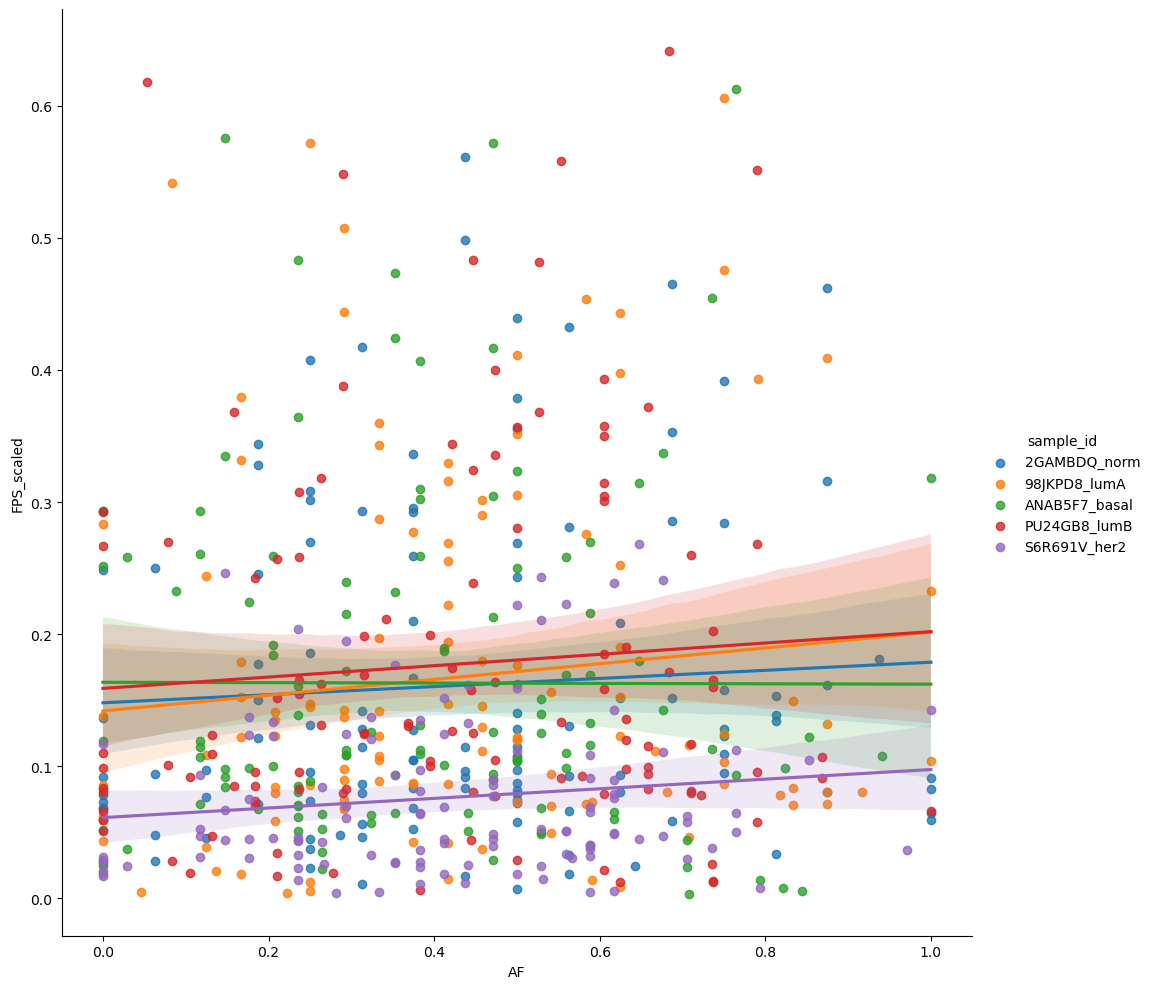

In [45]:
# plot jointplot of site_counts_sorted_top5
sns.lmplot(x='AF', y='FPS_scaled', data=covar_sites_sorted, hue='sample_id', fit_reg=True, height=10)

In [47]:
# test for correlation between AF and FPS_scaled for each subtype
from scipy.stats import spearmanr

# # Group by 'sample_id' and calculate the correlation for each group
# correlations = covar_sites_sorted.groupby('sample_id').apply(lambda group: spearmanr(group['AF'], group['FPS_scaled']), include_groups=False)

# correlations



How about we group by region_id?

In [48]:
covar_sites_sorted_novars = covar_sites_sorted.drop(columns=['AF_var', 'FPS_scaled_var'])

In [49]:
covar_sites_sorted_novars

sample_id        AF  FPS_scaled
region_id                                                    
chr1:977394-977405         2GAMBDQ_norm  1.000000    0.064366
chr1:977394-977405         98JKPD8_lumA  0.000000    0.059305
chr1:977394-977405        ANAB5F7_basal  0.000000    0.024563
chr1:977394-977405         PU24GB8_lumB  1.000000    0.066256
chr1:977394-977405         S6R691V_her2  0.000000    0.016988
...                                 ...       ...         ...
chr3:161854658-161854669   2GAMBDQ_norm  0.562500    0.018679
chr3:161854658-161854669   98JKPD8_lumA  0.625000    0.008329
chr3:161854658-161854669  ANAB5F7_basal  0.441176    0.064638
chr3:161854658-161854669   PU24GB8_lumB  0.736842    0.012126
chr3:161854658-161854669   S6R691V_her2  0.588235    0.004887

[590 rows x 3 columns]

In [50]:
# reset index to make region_id a column
covar_sites_sorted_novars = covar_sites_sorted_novars.reset_index()
covar_sites_sorted_novars

region_id      sample_id        AF  FPS_scaled
0          chr1:977394-977405   2GAMBDQ_norm  1.000000    0.064366
1          chr1:977394-977405   98JKPD8_lumA  0.000000    0.059305
2          chr1:977394-977405  ANAB5F7_basal  0.000000    0.024563
3          chr1:977394-977405   PU24GB8_lumB  1.000000    0.066256
4          chr1:977394-977405   S6R691V_her2  0.000000    0.016988
..                        ...            ...       ...         ...
585  chr3:161854658-161854669   2GAMBDQ_norm  0.562500    0.018679
586  chr3:161854658-161854669   98JKPD8_lumA  0.625000    0.008329
587  chr3:161854658-161854669  ANAB5F7_basal  0.441176    0.064638
588  chr3:161854658-161854669   PU24GB8_lumB  0.736842    0.012126
589  chr3:161854658-161854669   S6R691V_her2  0.588235    0.004887

[590 rows x 4 columns]

In [52]:
# get the rows where the region_id == chr10:24251881-24251892
covar_sites_sorted_novars[covar_sites_sorted_novars['region_id'] == 'chr10:73997814-73997825']

region_id      sample_id        AF  FPS_scaled
320  chr10:73997814-73997825   2GAMBDQ_norm  0.750000    0.391551
321  chr10:73997814-73997825   98JKPD8_lumA  0.875000    0.408824
322  chr10:73997814-73997825  ANAB5F7_basal  0.676471    0.336919
323  chr10:73997814-73997825   PU24GB8_lumB  0.657895    0.371692
324  chr10:73997814-73997825   S6R691V_her2  0.529412    0.210583

#### Spearman Correlation Test between AF and FPS_scaled

In [55]:
# Group by 'region_id' and calculate the correlation between AF and FPS_scaled for each group
correlations = covar_sites_sorted_novars.groupby('region_id').apply(lambda group: spearmanr(group['AF'], group['FPS_scaled']), include_groups=False)

correlations

region_id
chr10:15168778-15168789        (0.20519567041703085, 0.7405819415910722)
chr10:24251881-24251892        (0.09999999999999999, 0.8728885715695383)
chr10:73997814-73997825        (0.8999999999999998, 0.03738607346849875)
chr11:119121466-119121477                     (0.7, 0.18812040437418728)
chr11:560866-560877          (-0.49999999999999994, 0.39100221895577053)
                                                ...                     
chr9:88256422-88256433                        (-0.3, 0.6238376647810728)
chr9:92098292-92098303         (0.09999999999999999, 0.8728885715695383)
chr9:93095668-93095679                        (0.7, 0.18812040437418728)
chrX:119606547-119606558      (-0.09999999999999999, 0.8728885715695383)
chrX:24054420-24054431                        (0.6, 0.28475697986529375)
Length: 118, dtype: object

In [56]:
# that returned a pandas Series, so convert to dataframe
correlations_df = pd.DataFrame(correlations, columns=['corr_coeff_and_pvalue'])
# split the 'corr_coeff_and_pvalue' column into two separate columns using apply() and pd.Series
correlations_df[['corr_coeff', 'pvalue']] = correlations_df['corr_coeff_and_pvalue'].apply(pd.Series)
# drop the original column
correlations_df = correlations_df.drop(columns=['corr_coeff_and_pvalue']).reset_index()
correlations_df

region_id  corr_coeff    pvalue
0      chr10:15168778-15168789    0.205196  0.740582
1      chr10:24251881-24251892    0.100000  0.872889
2      chr10:73997814-73997825    0.900000  0.037386
3    chr11:119121466-119121477    0.700000  0.188120
4          chr11:560866-560877   -0.500000  0.391002
..                         ...         ...       ...
113     chr9:88256422-88256433   -0.300000  0.623838
114     chr9:92098292-92098303    0.100000  0.872889
115     chr9:93095668-93095679    0.700000  0.188120
116   chrX:119606547-119606558   -0.100000  0.872889
117     chrX:24054420-24054431    0.600000  0.284757

[118 rows x 3 columns]

In [57]:
# now sort region_id naturally
correlations_df_srt = correlations_df.reindex(index=index_natsorted(correlations_df['region_id']))
corr_df = correlations_df_srt.reset_index(drop=True)
corr_df

region_id  corr_coeff    pvalue
0          chr1:977047-977058    0.500000  0.391002
1          chr1:977174-977185    0.000000  1.000000
2          chr1:977206-977217    0.900000  0.037386
3          chr1:977394-977405    0.866025  0.057669
4        chr1:3857731-3857742   -0.300000  0.623838
..                        ...         ...       ...
113   chr22:39520618-39520629    0.700000  0.188120
114   chr22:42369353-42369364    0.500000  0.391002
115   chr22:50474997-50475008   -0.200000  0.747060
116    chrX:24054420-24054431    0.600000  0.284757
117  chrX:119606547-119606558   -0.100000  0.872889

[118 rows x 3 columns]

In [58]:
# filter for pvalue < 0.05
corr_df_sig = corr_df[corr_df['pvalue'] < 0.05]
corr_df_sig

region_id  corr_coeff        pvalue
2          chr1:977206-977217         0.9  3.738607e-02
65    chr10:73997814-73997825         0.9  3.738607e-02
75  chr12:120291913-120291924        -0.9  3.738607e-02
77    chr13:98484867-98484878         1.0  1.404265e-24
88        chr16:382034-382045         0.9  3.738607e-02
95    chr17:18682506-18682517        -0.9  3.738607e-02

#### Multiple Testing Correction
Now we need to correct for multiple testing. We can use the Benjamini-Hochberg method to correct for multiple testing.

In [59]:
from statsmodels.stats.multitest import multipletests

# apply Benjamini/Hochberg FDR correction
pvals = corr_df['pvalue']
fdr_corr = multipletests(pvals, alpha=0.05, method='fdr_bh')
fdr_corr

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False]),
 array([8.87274266e-01, 1.00000000e+00, 7.35259445e-01, 8.87

In [60]:
# add the corrected pvalues to the dataframe
corr_df_corrected = corr_df.copy()
corr_df_corrected['fdr_adj_pvalue'] = fdr_corr[1]

# filter for corrected pvalue < 0.05
corr_df_corrected_sig = corr_df_corrected[corr_df_corrected['fdr_adj_pvalue'] < 0.05]
corr_df_corrected_sig

region_id  corr_coeff        pvalue  fdr_adj_pvalue
77  chr13:98484867-98484878         1.0  1.404265e-24    1.657033e-22

#### ASIDE: Visualization of Correlation Coefficients at Filtered Covariant Sites

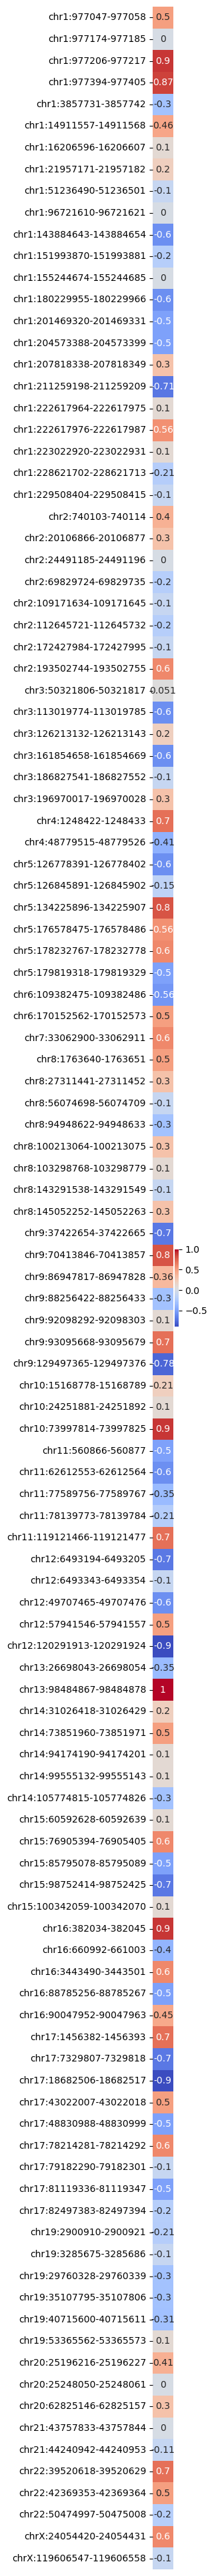

In [147]:
corr_df_i = corr_df.set_index('region_id')

# Convert the DataFrame to a 2D format suitable for a heatmap
df_2d = corr_df_i['corr_coeff'].to_numpy().reshape(-1, 1)

# Create a heatmap
plt.figure(figsize=(0.5,50))  # Adjust the figure size as needed
sns.heatmap(df_2d, annot=True, cmap='coolwarm', xticklabels=False, yticklabels=corr_df_i.index)
plt.show()